<a href="https://colab.research.google.com/github/EurousZhao/Group-1/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we explore the performance of deep neural network architectures to forecast time series energy price data. We investigate Convolutional Neural Networks (CNN), Time Distributed Feed-Forward Neural Networks, Long Short-term Memory Recurrent Neural Networks (LSTM) and Stacked Neural Networks. In addition, perform time series analysis on our data set and discuss some of the theoretical aspects of our approaches in each relevant section.

## The Data Set


In this project, we are using a combination of two data sets as our data set. It provides hourly information on electricity generation and weather in Spain from 2015 to 2019.

- `weather_features.csv` Contains hourly information about the weather conditions: temperature, wind speed, humidity, rainfall, and qualitative description of 5 major cities in Spain (Madrid, Barcelona, Valencia, Seville and Bilbao). The key aspects of the dataset include:  
  * Time, date and city name  
  * Temperature Measurements: include the actual temperature at the time of observation and minimum, maximum temperature recorded during the hour.
  * Atmospheric Pressure and Humidity  
  * Wind speed and direction of the wind in degrees
  * Precipitation Data like the amount of rain/snow in millimeters that fell during the past hour/3 hours.  
  * General Weather Conditions like weather_description and weather_main.
- `energy_dataset.csv` Contains hourly information about the amount of electricity generated (in Mw) categorised by its kind (with major providers for Spain being fossil gas, fossil hard coal and wind energy) in relation to the energy demand.The key components of the dataset include:  
  * Electricity Generation Data:   
  Includes a wide range of generation sources like Renewable Energy Sources(Biomass, Geothermal, Hydro (including pumped storage aggregated, pumped storage consumption, run-of-river and poundage, and water reservoir),Solar and Wind). Fossil Fuel-Based Sources (Brown coal/lignite,Coal-derived gas,Gas,Hard,coal,Oil), and other source like Nuclear, Waste.  
  * Generation Forecasts:  
  Provides day-ahead forecasts for solar, wind offshore, and wind onshore generation, crucial for grid management and planning.  
  * Load Data:  
  Includes Total Load Forecast(Predicted electricity demand) and
  Total Load Actual for Actual electricity demand, useful for comparing against forecasts and understanding real-world consumption patterns.  
  * Pricing Data:  
  Includes Price Day Ahead( Predicted electricity prices) and Price Actual( Actual electricity prices).


The data is sourced from  https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, TimeDistributed
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
energy_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/energy_dataset.csv'
weather_url = 'https://raw.githubusercontent.com/EurousZhao/Group-1/main/data/weather_features.csv'
df_energy = pd.read_csv(energy_url, parse_dates=['time'])
df_weather = pd.read_csv(weather_url, parse_dates=['dt_iso'])

In [3]:
# show all colunms of dataset
pd.set_option('display.max_columns', None)

# Data Preprocessing

### Electricity dataframe

In [4]:
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            4126.000000   
50%                                   0.0            4969.000000   
75%                                   0.0            6429.000000   
max                                   0.0           20034.000000   

       generation fossil hard coal  generation fossil oil  \
count                 35046.000000           35045.000000   
mean                   4256.065742             298.319789   
std                    1961.601013              52.520673   
min                       0.000000               0.000000   
25%                    2527.000000             263.000000   
50%                    4474.000000             300.000000   
75%                    5838.750000             330.000000   
max                    8359.000000             449.000000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage aggregated  \
count                35046.0                                         0.0   
mean                     0.0                                         NaN   
std                      0.0                                         NaN   
min                      0.0                                         NaN   
25%                      0.0                                         NaN   
50%                      0.0                                         NaN   
75%                      0.0                                         NaN   
max                      0.0                                         NaN   

       generation hydro pumped storage consumption  \
count                                 35045.000000   
mean                                    475.577343   
std                                     792.406614   
min                                       0.000000   
25%                                       0.000000   
50%                                      68.000000   
75%                                     616.000000   
max                                    4523.000000   

       generation hydro run-of-river and poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water r

We can notice there are a lot of zero or missing values in the dataset like: 'generation hydro pumped storage aggregated'. First we need to determine whether all of these columns are 0 values or nan values, and if so, delete them.

In [5]:
df_energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

So we can notice that there are a lot of columns for which enteries are missing but below 40 instances. So we will attempt filling missing values with linear interpolation.

We don't want to linearly interpolate time so we will seperate it into index right away.

However the entirety of `generation hydro pumped storage aggregated` and `forecast wind offshore eday ahead` is missing. Hence we will remove these columns.

Also we don't need data's predictions so we will drop forcast columns.

In [6]:
empty_columns = ['generation fossil coal-derived gas','generation fossil oil shale',
                 'generation fossil peat', 'generation geothermal',
                 'generation hydro pumped storage aggregated', 'generation marine',
                 'generation wind offshore']

forcast_columns = ['forecast wind offshore eday ahead', 'total load forecast',
                   'forecast solar day ahead', 'forecast wind onshore day ahead']

df_energy = df_energy.drop(empty_columns + forcast_columns, axis=1)

**EXPLAIN CHANGE OF TIMEZONE**

In [7]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)
df_energy['time'] = df_energy['time'].dt.tz_convert('CET').dt.tz_localize(None)
df_energy = df_energy.drop_duplicates(subset=['time'], keep='first').set_index('time')

In [8]:
df_energy = df_energy.interpolate('linear')

In [9]:
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [10]:
#check all columns variable type
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35060 entries, 2015-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35060 non-null  float64
 1   generation fossil brown coal/lignite         35060 non-null  float64
 2   generation fossil gas                        35060 non-null  float64
 3   generation fossil hard coal                  35060 non-null  float64
 4   generation fossil oil                        35060 non-null  float64
 5   generation hydro pumped storage consumption  35060 non-null  float64
 6   generation hydro run-of-river and poundage   35060 non-null  float64
 7   generation hydro water reservoir             35060 non-null  float64
 8   generation nuclear                           35060 non-null  float64
 9   generation other                     

## Weather dataframe

In [11]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

The features describing weather conditions are somewhat repetitive, which are not particularly helpful for predicting electricity prices, so they are deleted.

In [12]:
# cancel meaningless object variables
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [13]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  int64  
 6   humidity    178396 non-null  int64  
 7   wind_speed  178396 non-null  int64  
 8   wind_deg    178396 non-null  int64  
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 17.7+ MB


In [14]:
to_convert = ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all']

for column in to_convert:
  df_weather[column] = df_weather[column].astype(float)

change time column type

In [15]:
# change time column "dt_iso" to dateindex type
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather['time'] = df_weather['time'].dt.tz_convert('CET').dt.tz_localize(None)

In [16]:
# remove duplicates so data matches
cities = df_weather['city_name'].unique()

for city in cities:
  print(df_weather.groupby('city_name').get_group(city).shape[0])

35145
36267
35951
35476
35557


Remove duplicates

In [17]:
df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [18]:
# check have null value or not
df_weather.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

In [19]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175300 entries, 2015-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   city_name   175300 non-null  object 
 1   temp        175300 non-null  float64
 2   temp_min    175300 non-null  float64
 3   temp_max    175300 non-null  float64
 4   pressure    175300 non-null  float64
 5   humidity    175300 non-null  float64
 6   wind_speed  175300 non-null  float64
 7   wind_deg    175300 non-null  float64
 8   rain_1h     175300 non-null  float64
 9   rain_3h     175300 non-null  float64
 10  snow_3h     175300 non-null  float64
 11  clouds_all  175300 non-null  float64
dtypes: float64(11), object(1)
memory usage: 17.4+ MB


In [20]:
df_weather.groupby('city_name').mean()

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.867558  288.615382  291.039827  1287.242099  73.828494   
Bilbao      286.444060  284.990533  288.091000  1017.484284  78.729236   
Madrid      288.277833  287.052421  289.372757  1011.782145  58.722989   
Seville     293.166996  291.260039  296.002281  1018.536994  63.779122   
Valencia    290.784488  290.226115  291.358501  1015.980120  65.091786   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  
city_name                                                                     
 Barcelona    2.782944  187.658842  0.108500  0.000331  0.000000   22.714347  
Bilbao        1.958414  159.905077  0.119153  0.001057  0.024051   43.436965  
Madrid        2.433913  173.363035  0.043306  0.000133  0.000030   20.663120  
Seville       2.482801  151.882459  0.041141  0.000182  0.000000   14.166686  
Valencia      2.692670  160.793582  0.034462  0.000227  0.000154   20.740702

Removing outliers

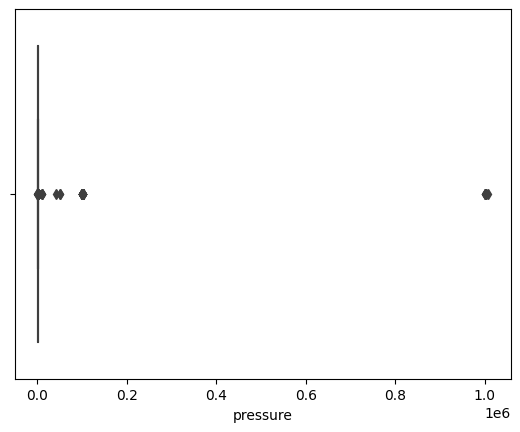

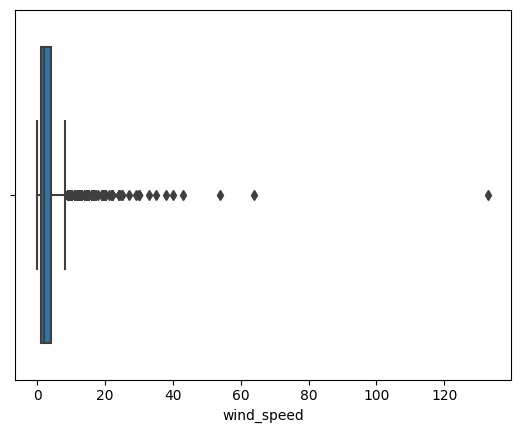

In [21]:
sns.boxplot(x=df_weather['pressure'])
plt.show()
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

Set values which are above bounderies of extremes to NaN so we can interpolate them.

- Highest pressure recorded is 1050 in 2015 (ref. https://www.levante-emv.com/opinion/2015/01/27/presion-record-lugares-espana-enero-12677646.html)
- Lowest pressure recorded is 950 hPa in 1941 (ref. https://documentacion.fundacionmapfre.org/documentacion/publico/i18n/media/group/1021716.do)

In [22]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 951, 'pressure'] = np.nan
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan
df_weather.interpolate(method='linear', inplace=True, axis=0)

## Combining the data sets

We first split df_weather into seperate data sets for each of the 5 cities. We then combine df_energy which has 35064 rows and df_weather which has 178396 rows. After, we convert the data set from hourly price values to daily maximum price values.

In [23]:
# Split the df_weather into 5 dataframes (one for each city)

dfs = [x for _, x in df_weather.groupby('city_name')]

use loop to rename colunm names for all 5 cities dataset and merge to df_energy dataset and finally drop the city_name column

In [24]:
dataset = df_energy
cities[3] = 'Barcelona'

for city, df in zip(cities, dfs):
    df = df.add_suffix(f'_{city}')
    dataset = dataset.merge(df, on=['time'], how='outer')
    dataset = dataset.drop(f'city_name_{city}', axis=1)

dataset.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Valencia', 'temp_min_Valencia',
       'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'rain_3h_Valencia', 'snow_3h_Valencia', 'clouds_all_Valencia',
       'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid',
       'clouds_all_Mad

We convert the data set from hourly observations to daily maximum price observations. This eases the computational cost of our models.

In [25]:
dataset = dataset.resample('D').max()
df_energy = df_energy.resample('D').max()

# EDA and Time Series Analysis

In [26]:
dataset.head()

generation biomass  generation fossil brown coal/lignite  \
time                                                                   
2015-01-01               449.0                                 329.0   
2015-01-02               443.0                                   0.0   
2015-01-03               478.0                                   0.0   
2015-01-04               438.0                                   0.0   
2015-01-05               376.0                                 326.0   

            generation fossil gas  generation fossil hard coal  \
time                                                             
2015-01-01                 5196.0                       5043.0   
2015-01-02                 6082.0                       1432.0   
2015-01-03                 4157.0                       1798.0   
2015-01-04                 3997.0                       2755.0   
2015-01-05                 5699.0                       4247.0   

            generation fossil oil  \
time                                
2015-01-01                  167.0   
2015-01-02                  220.0   
2015-01-03                  250.0   
2015-01-04                  394.0   
2015-01-05                  352.0   

            generation hydro pumped storage consumption  \
time                                                      
2015-01-01                                       2170.0   
2015-01-02                                       3269.0   
2015-01-03                                       2953.0   
2015-01-04                                       2185.0   
2015-01-05                                       2365.0   

            generation hydro run-of-river and poundage  \
time                                                     
2015-01-01                                      1220.0   
2015-01-02                                      1370.0   
2015-01-03                                      1583.0   
2015-01-04                                      1616.0   
2015-01-05                                      1328.0   

            generation hydro water reservoir  generation nuclear  \
time                                                               
2015-01-01                            6231.0              7099.0   
2015-01-02                            5902.0              7108.0   
2015-01-03                            5985.0              7099.0   
2015-01-04                            5936.0              7088.0   
2015-01-05                            3732.0              4036.0   

            generation other  generation other renewable  generation solar  \
time                                                                         
2015-01-01              43.0                        76.0            4007.0   
2015-01-02              45.0                        69.0            4154.0   
2015-01-03              83.0                        76.0            3780.0   
2015-01-04              87.0                        61.0            5668.0   
2015-01-05              45.0                        76.0            3339.0   

            generation waste  generation wind onshore  total load actual  \
time                                                                       
2015-01-01             212.0                   6378.0            29571.0   
2015-01-02             204.0                  13232.0            33668.0   
2015-01-03             222.0                  10953.0            29874.0   
2015-01-04             177.0                   8922.0            30772.0   
2015-01-05             161.0                   9131.0            25604.0   

            price day ahead  price actual  temp_Valencia  temp_min_Valencia  \
time                                                                          
2015-01-01            62.69         75.64     284.602312         284.602312   
2015-01-02            52.01         83.33     286.328688         286.328688   
2015-01-03            44.00         72.86     287.148000         287.148000   
2015-01-04 

In [27]:
dataset.tail()

generation biomass  generation fossil brown coal/lignite  \
time                                                                   
2018-12-27               320.0                                 722.0   
2018-12-28               328.0                                 721.0   
2018-12-29               314.0                                 113.0   
2018-12-30               288.0                                   0.0   
2018-12-31               307.0                                   0.0   

            generation fossil gas  generation fossil hard coal  \
time                                                             
2018-12-27                13292.0                       2983.0   
2018-12-28                10265.0                       3019.0   
2018-12-29                 5545.0                       2120.0   
2018-12-30                 5859.0                       1901.0   
2018-12-31                 7634.0                       2773.0   

            generation fossil oil  \
time                                
2018-12-27                  316.0   
2018-12-28                  294.0   
2018-12-29                  268.0   
2018-12-30                  231.0   
2018-12-31                  225.0   

            generation hydro pumped storage consumption  \
time                                                      
2018-12-27                                        719.0   
2018-12-28                                        412.0   
2018-12-29                                       2501.0   
2018-12-30                                       2217.0   
2018-12-31                                        708.0   

            generation hydro run-of-river and poundage  \
time                                                     
2018-12-27                                      1305.0   
2018-12-28                                      1229.0   
2018-12-29                                      1230.0   
2018-12-30                                      1167.0   
2018-12-31                                      1172.0   

            generation hydro water reservoir  generation nuclear  \
time                                                               
2018-12-27                            7169.0              6074.0   
2018-12-28                            5030.0              6075.0   
2018-12-29                            3164.0              6076.0   
2018-12-30                            4248.0              6074.0   
2018-12-31                            4836.0              6076.0   

            generation other  generation other renewable  generation solar  \
time                                                                         
2018-12-27              63.0                        98.0            2603.0   
2018-12-28              61.0                       104.0            2155.0   
2018-12-29              62.0                       103.0            2925.0   
2018-12-30              62.0                       103.0            3833.0   
2018-12-31              63.0                        96.0            3906.0   

            generation waste  generation wind onshore  total load actual  \
time                                                                       
2018-12-27             308.0                   1658.0            33142.0   
2018-12-28             315.0                   7062.0            33200.0   
2018-12-29             319.0                   7807.0            30819.0   
2018-12-30             318.0                   6578.0            30229.0   
2018-12-31             313.0                   4409.0            30653.0   

            price day ahead  price actual  temp_Valencia  temp_min_Valencia  \
time                                                                          
2018-12-27            71.97         81.12         287.14             286.15   
2018-12-28            70.16         78.26         286.65             286.15   
2018-12-29            65.27         71.01         285.65             285.15   
2018-12-30 

In [28]:
dataset.describe()

generation biomass  generation fossil brown coal/lignite  \
count         1461.000000                           1461.000000   
mean           400.982204                            530.977413   
std             86.669888                            375.123226   
min            193.000000                              0.000000   
25%            350.000000                              0.000000   
50%            381.000000                            632.000000   
75%            470.000000                            918.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count            1461.000000                  1461.000000   
mean             7033.427789                  4812.262149   
std              2617.860154                  1920.718583   
min              2471.000000                   734.000000   
25%              5121.000000                  3214.000000   
50%              6290.000000                  5147.000000   
75%              8270.000000                  6312.000000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count            1461.000000                                  1461.000000   
mean              323.475017                                  1534.866530   
std                51.171029                                  1085.227387   
min               167.000000                                     0.000000   
25%               296.000000                                   635.000000   
50%               323.000000                                  1290.000000   
75%               350.000000                                  2312.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                 1461.000000   
mean                                  1075.647502   
std                                    404.493534   
min                                    363.000000   
25%                                    733.000000   
50%                                   1021.000000   
75%                                   1364.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                       1461.000000         1461.000000       1461.000000   
mean                        4752.311431         6308.738535         65.015058   
std                         1777.362892          825.615356         19.998933   
min                          992.000000         3740.000000          7.000000   
25%                         3441.000000         5912.000000         56.000000   
50%                         4564.000000         6708.000000         62.000000   
75%                         5885.000000         7057.000000         83.000000   
max                         9728.000000         7117.000000        106.000000   

       generation other renewable  generation solar  generation waste  \
count                 1461.000000       1461.000000       1461.000000   
mean                    91.755647       3816.230664        283.570842   
std                     13.854028       1347.931949         49.378826   
min                     55.000000        566.000000        122.000000   
25%                     79.000000       2741.000000        259.000000   
50%                     94.000000       4078.000000        294.000000   
75%                    103.000000       5060.000000        324.000000   
max                    119.000000       5792.000000        357.000000   

       generation wind onshore  total load actual  price day ahead  \
count               1461.00000        1461.000000      1461.000000   
mean                7449.63655       33198.973306        59.497351   
std                 3201.38070        3214.243914        12.299607   
min          

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2015-01-01 to 2018-12-31
Freq: D
Data columns (total 72 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           1461 non-null   float64
 1   generation fossil brown coal/lignite         1461 non-null   float64
 2   generation fossil gas                        1461 non-null   float64
 3   generation fossil hard coal                  1461 non-null   float64
 4   generation fossil oil                        1461 non-null   float64
 5   generation hydro pumped storage consumption  1461 non-null   float64
 6   generation hydro run-of-river and poundage   1461 non-null   float64
 7   generation hydro water reservoir             1461 non-null   float64
 8   generation nuclear                           1461 non-null   float64
 9   generation other                             146

In [30]:
dataset.isnull().sum()

generation biomass                      0
generation fossil brown coal/lignite    0
generation fossil gas                   0
generation fossil hard coal             0
generation fossil oil                   0
                                       ..
wind_deg_Seville                        0
rain_1h_Seville                         0
rain_3h_Seville                         0
snow_3h_Seville                         0
clouds_all_Seville                      0
Length: 72, dtype: int64

Plot price_actual according time index and use function rolling(sum of data over time / time period) to plot a rolling average line base on the price actual. source from [Rolling Averages](https://www.indeed.com/career-advice/career-development/what-is-rolling-average).

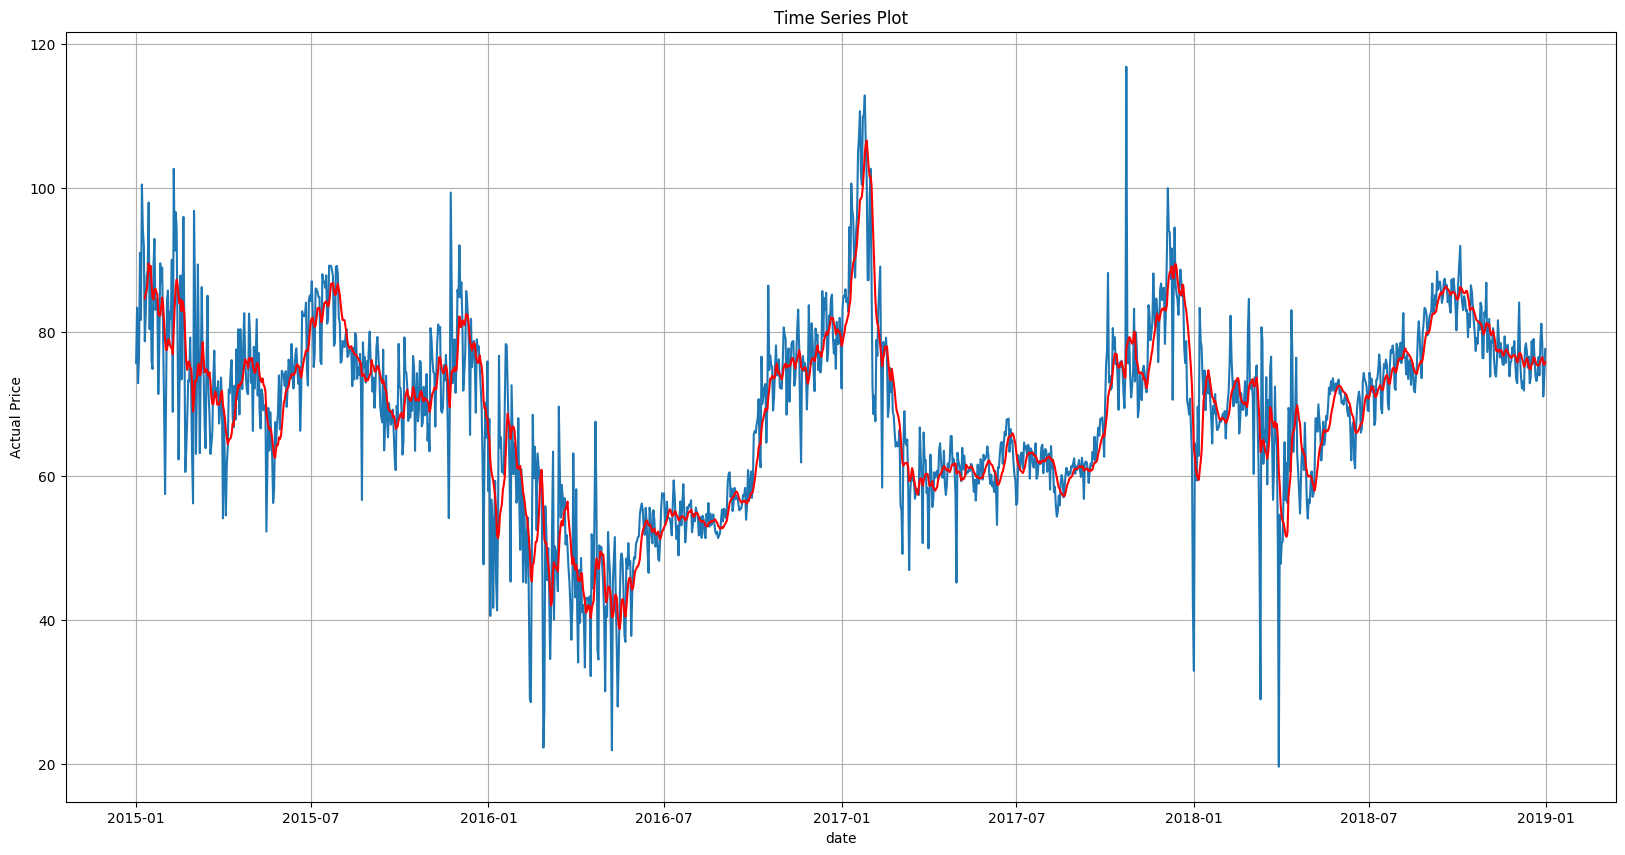

In [31]:
import seaborn as sns

# Set the rolling window size for the average
window_size = 10  # 10-period rolling average

# Calculate the rolling average
rolling_avg = dataset['price actual'].rolling(window=window_size).mean()


# Seaborn line plot
plt.figure(figsize=(20, 10))
sns.lineplot(x=dataset.index, y=dataset['price actual'])

# Plot the rolling average line
plt.plot(dataset.index, rolling_avg, color='r', linestyle='-', label=f'{window_size}-Period Rolling Average')

plt.title('Time Series Plot')
plt.xlabel('date')
plt.ylabel('Actual Price')
plt.grid(True)
plt.show()


plot from 2015 to 2019, Rainfall and snowfall in five cities.

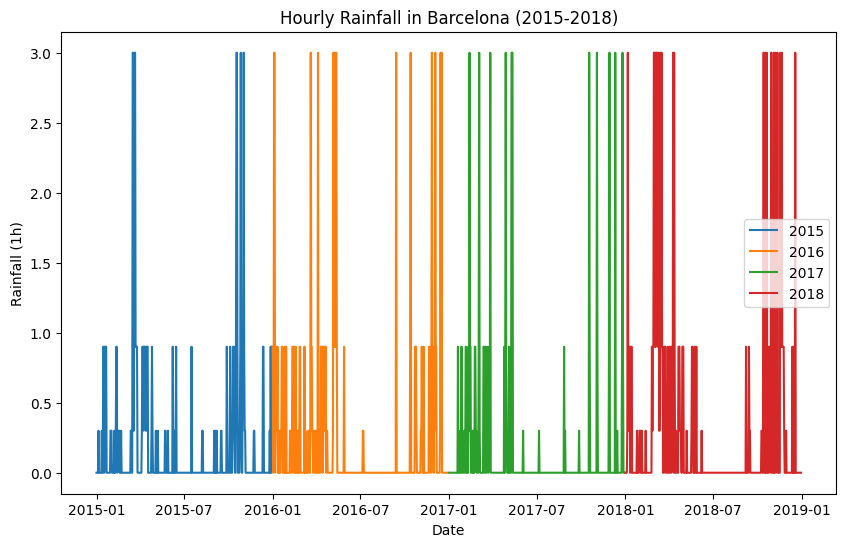

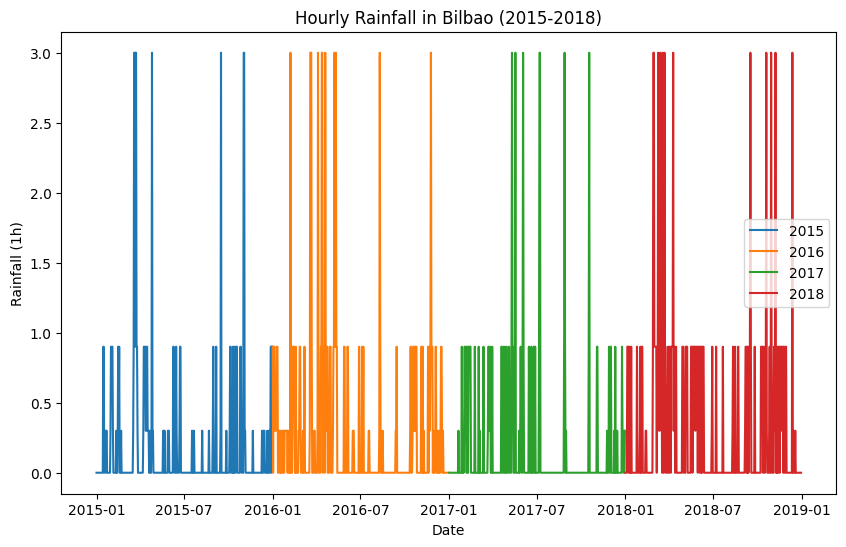

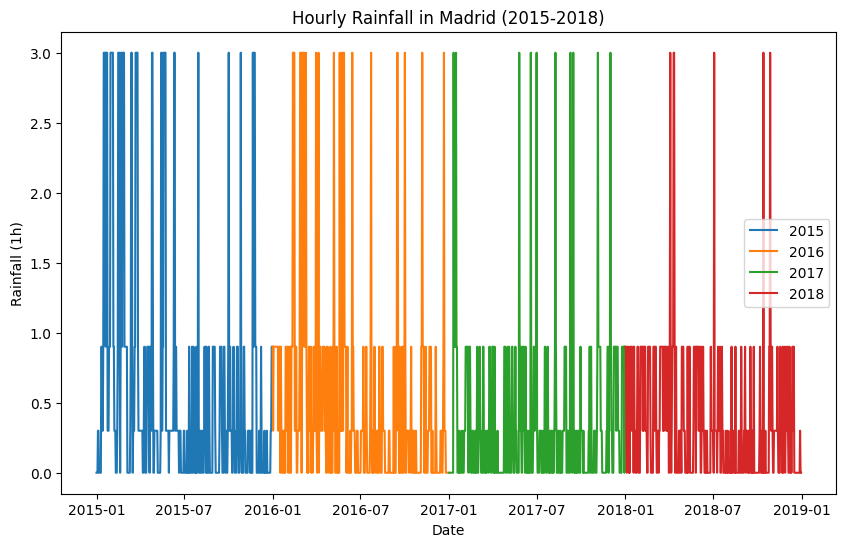

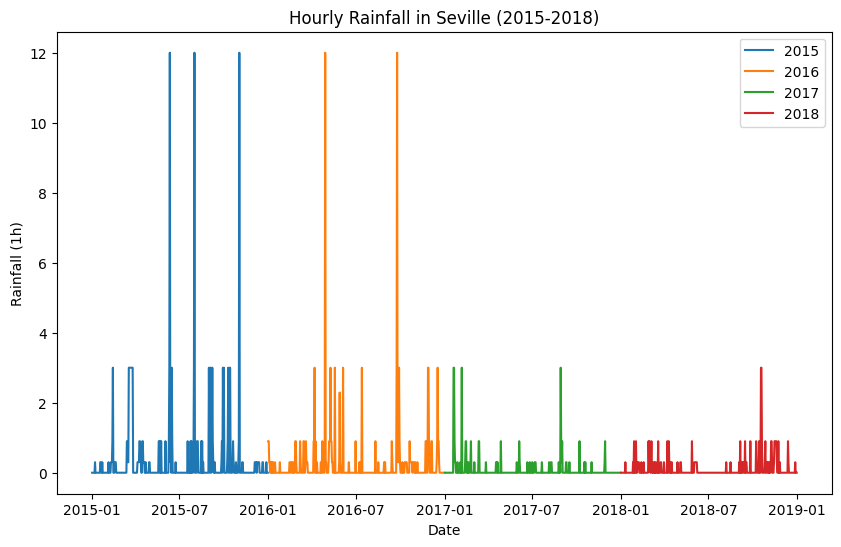

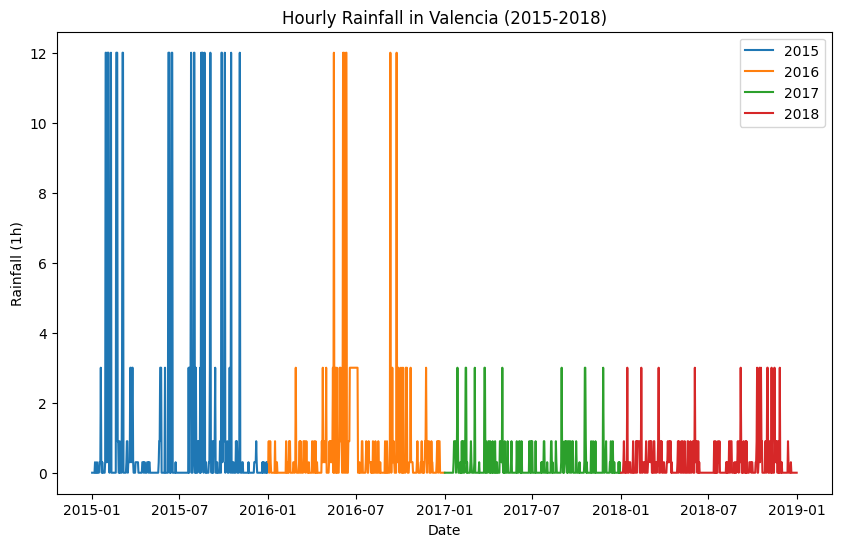

In [32]:
# Extract years from the dateindex
dataset['year'] = dataset.index.year

# List of cities
cities = ["Barcelona", "Bilbao", "Madrid", "Seville", "Valencia"]

# Create a separate graph for each city
for city in cities:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Plot a line graph for the 'rain_1h' data of each city across all years
    for year in range(2015, 2019):  # Including 2019
        year_data = dataset[dataset['year'] == year]
        plt.plot(year_data.index, year_data[f'rain_1h_{city}'], label=f'{year}')

    plt.title(f'Hourly Rainfall in {city} (2015-2018)')
    plt.xlabel('Date')
    plt.ylabel('Rainfall (1h)')
    plt.legend()
    plt.show()


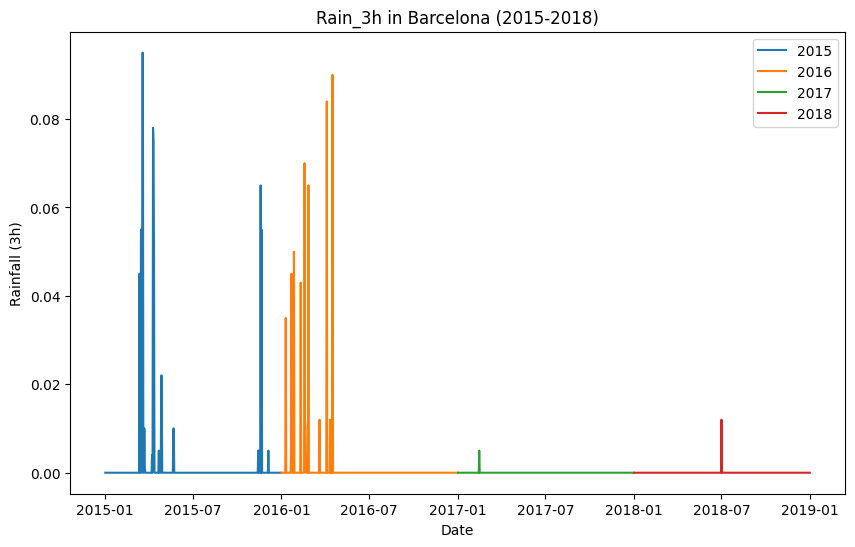

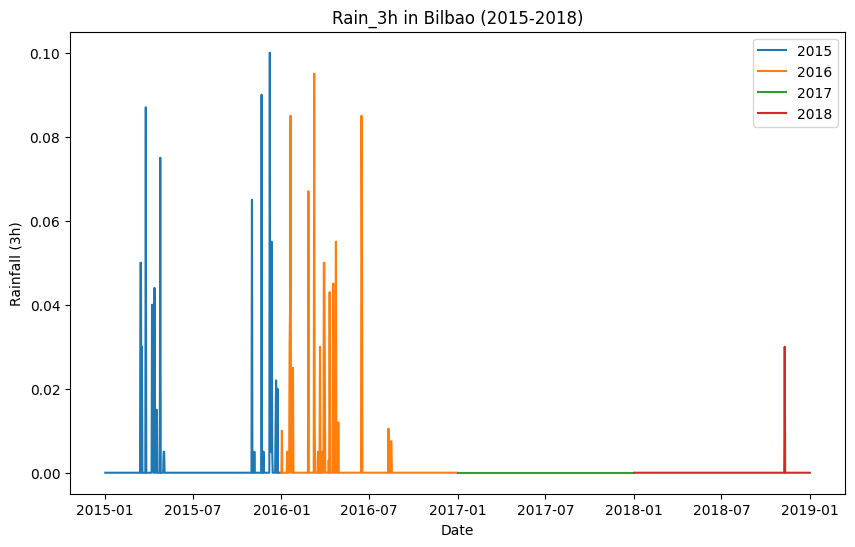

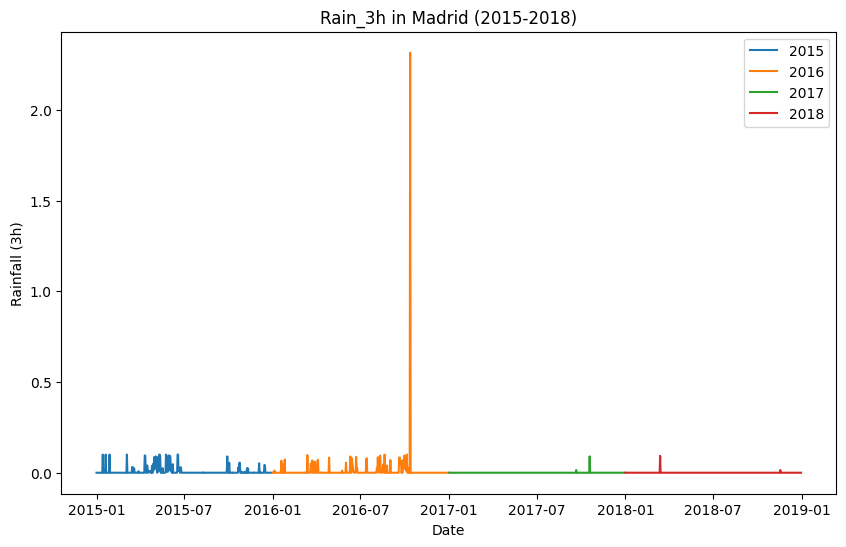

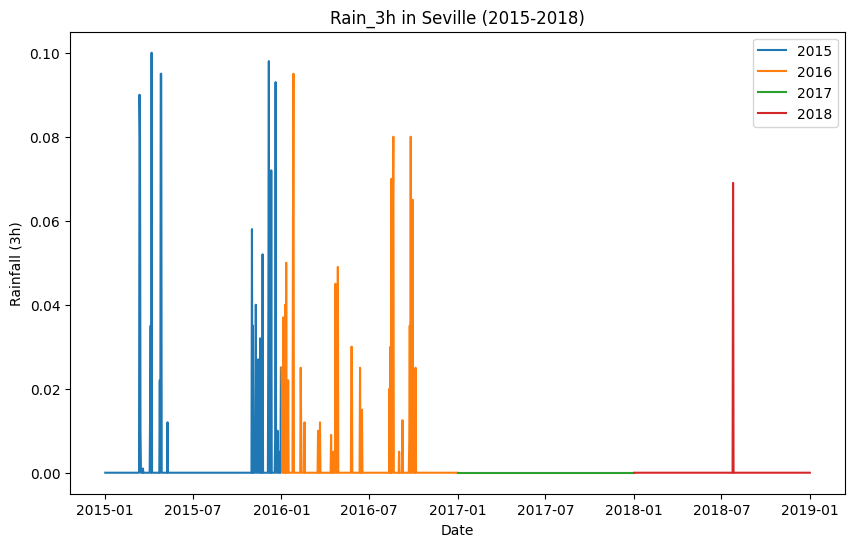

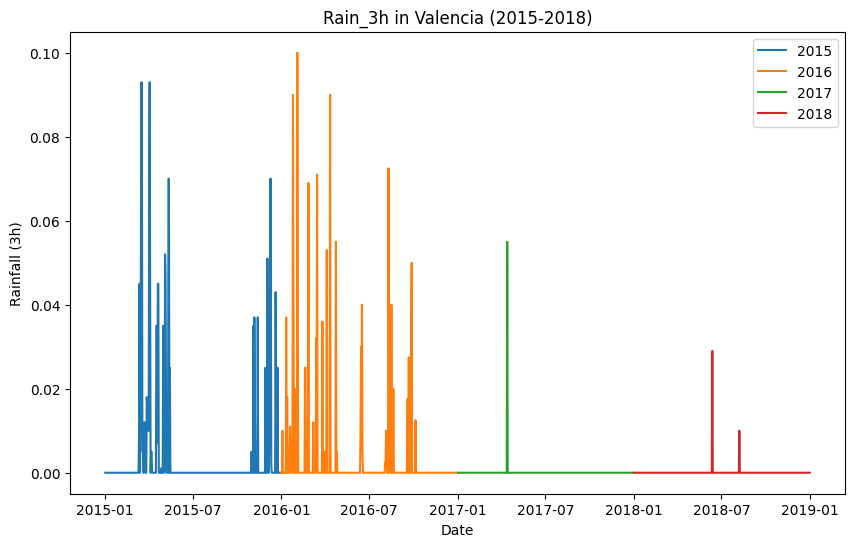

In [33]:
# Extract years from the dateindex
dataset['year'] = dataset.index.year

# List of cities
cities = ["Barcelona", "Bilbao", "Madrid", "Seville", "Valencia"]

# Create a separate graph for each city
for city in cities:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Plot a line graph for the 'rain_1h' data of each city across all years
    for year in range(2015, 2019):  # Including 2019
        year_data = dataset[dataset['year'] == year]
        plt.plot(year_data.index, year_data[f'rain_3h_{city}'], label=f'{year}')

    plt.title(f'Rain_3h in {city} (2015-2018)')
    plt.xlabel('Date')
    plt.ylabel('Rainfall (3h)')
    plt.legend()
    plt.show()


We can conclude that 'rain_3h' is an unreliable feature so we will drop it.

In [34]:
for city in cities:
    dataset = dataset.drop([f'rain_3h_{city}'], axis=1)

plot comparing the prices of a randomly chosen two-week period across five years (2015 to 2019)

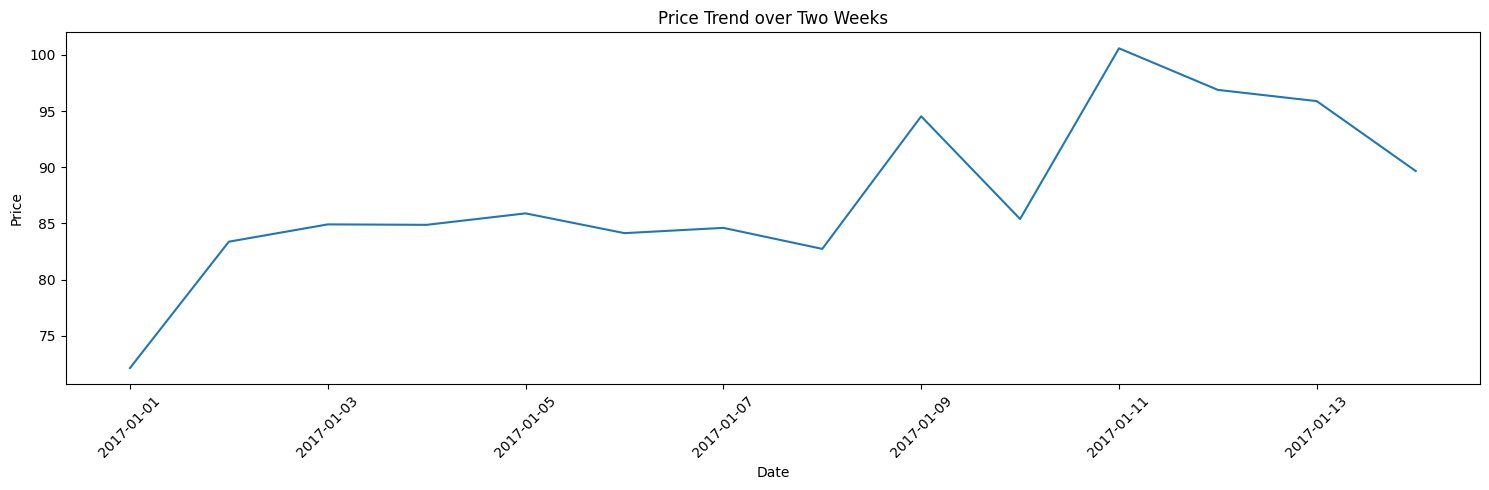

In [35]:
# Plotting 2 weeks of data
start_date = '2017-01-01'
end_date = '2017-01-14'
two_weeks_data = dataset.loc[start_date:end_date]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(two_weeks_data.index, two_weeks_data['price actual'])
plt.title('Price Trend over Two Weeks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

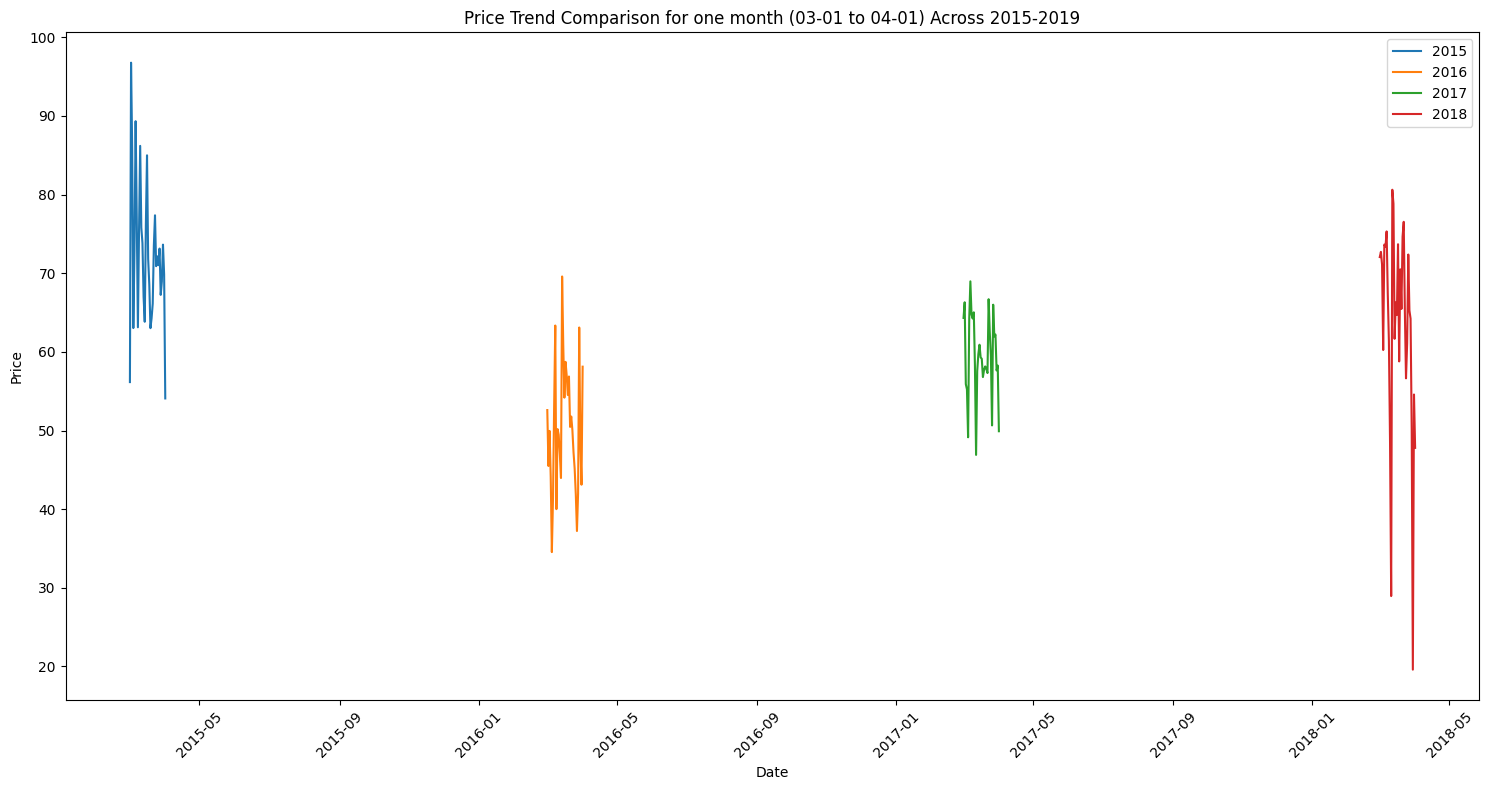

In [36]:
one_month_period_start = '03-01'
one_month_period_end = '04-01'

# Creating the plot again with the adjusted dates
plt.figure(figsize=(15, 8))

# Plotting data for each year from 2015 to 2019
for year in range(2015, 2019):
    start_date = f'{year}-{one_month_period_start}'
    end_date = f'{year}-{one_month_period_end}'
    one_month_data = dataset[start_date:end_date]
    plt.plot(one_month_data.index, one_month_data['price actual'], label=f'{year}')

# Setting up the plot
plt.title('Price Trend Comparison for one month (03-01 to 04-01) Across 2015-2019')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


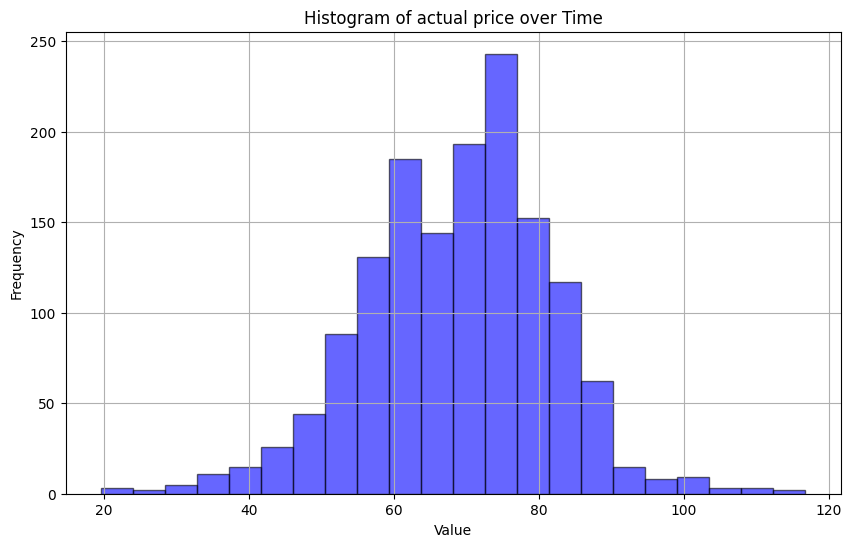

In [37]:
# Plot histogram
plt.figure(figsize=(10, 6))
dataset['price actual'].hist(bins=22, alpha=0.6, color='blue', edgecolor='black')
plt.title('Histogram of actual price over Time')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


We obsorved that the actual energy price follows normal distribution allowing us to standardise it.

Plot every feature's histgram and check the data distibution

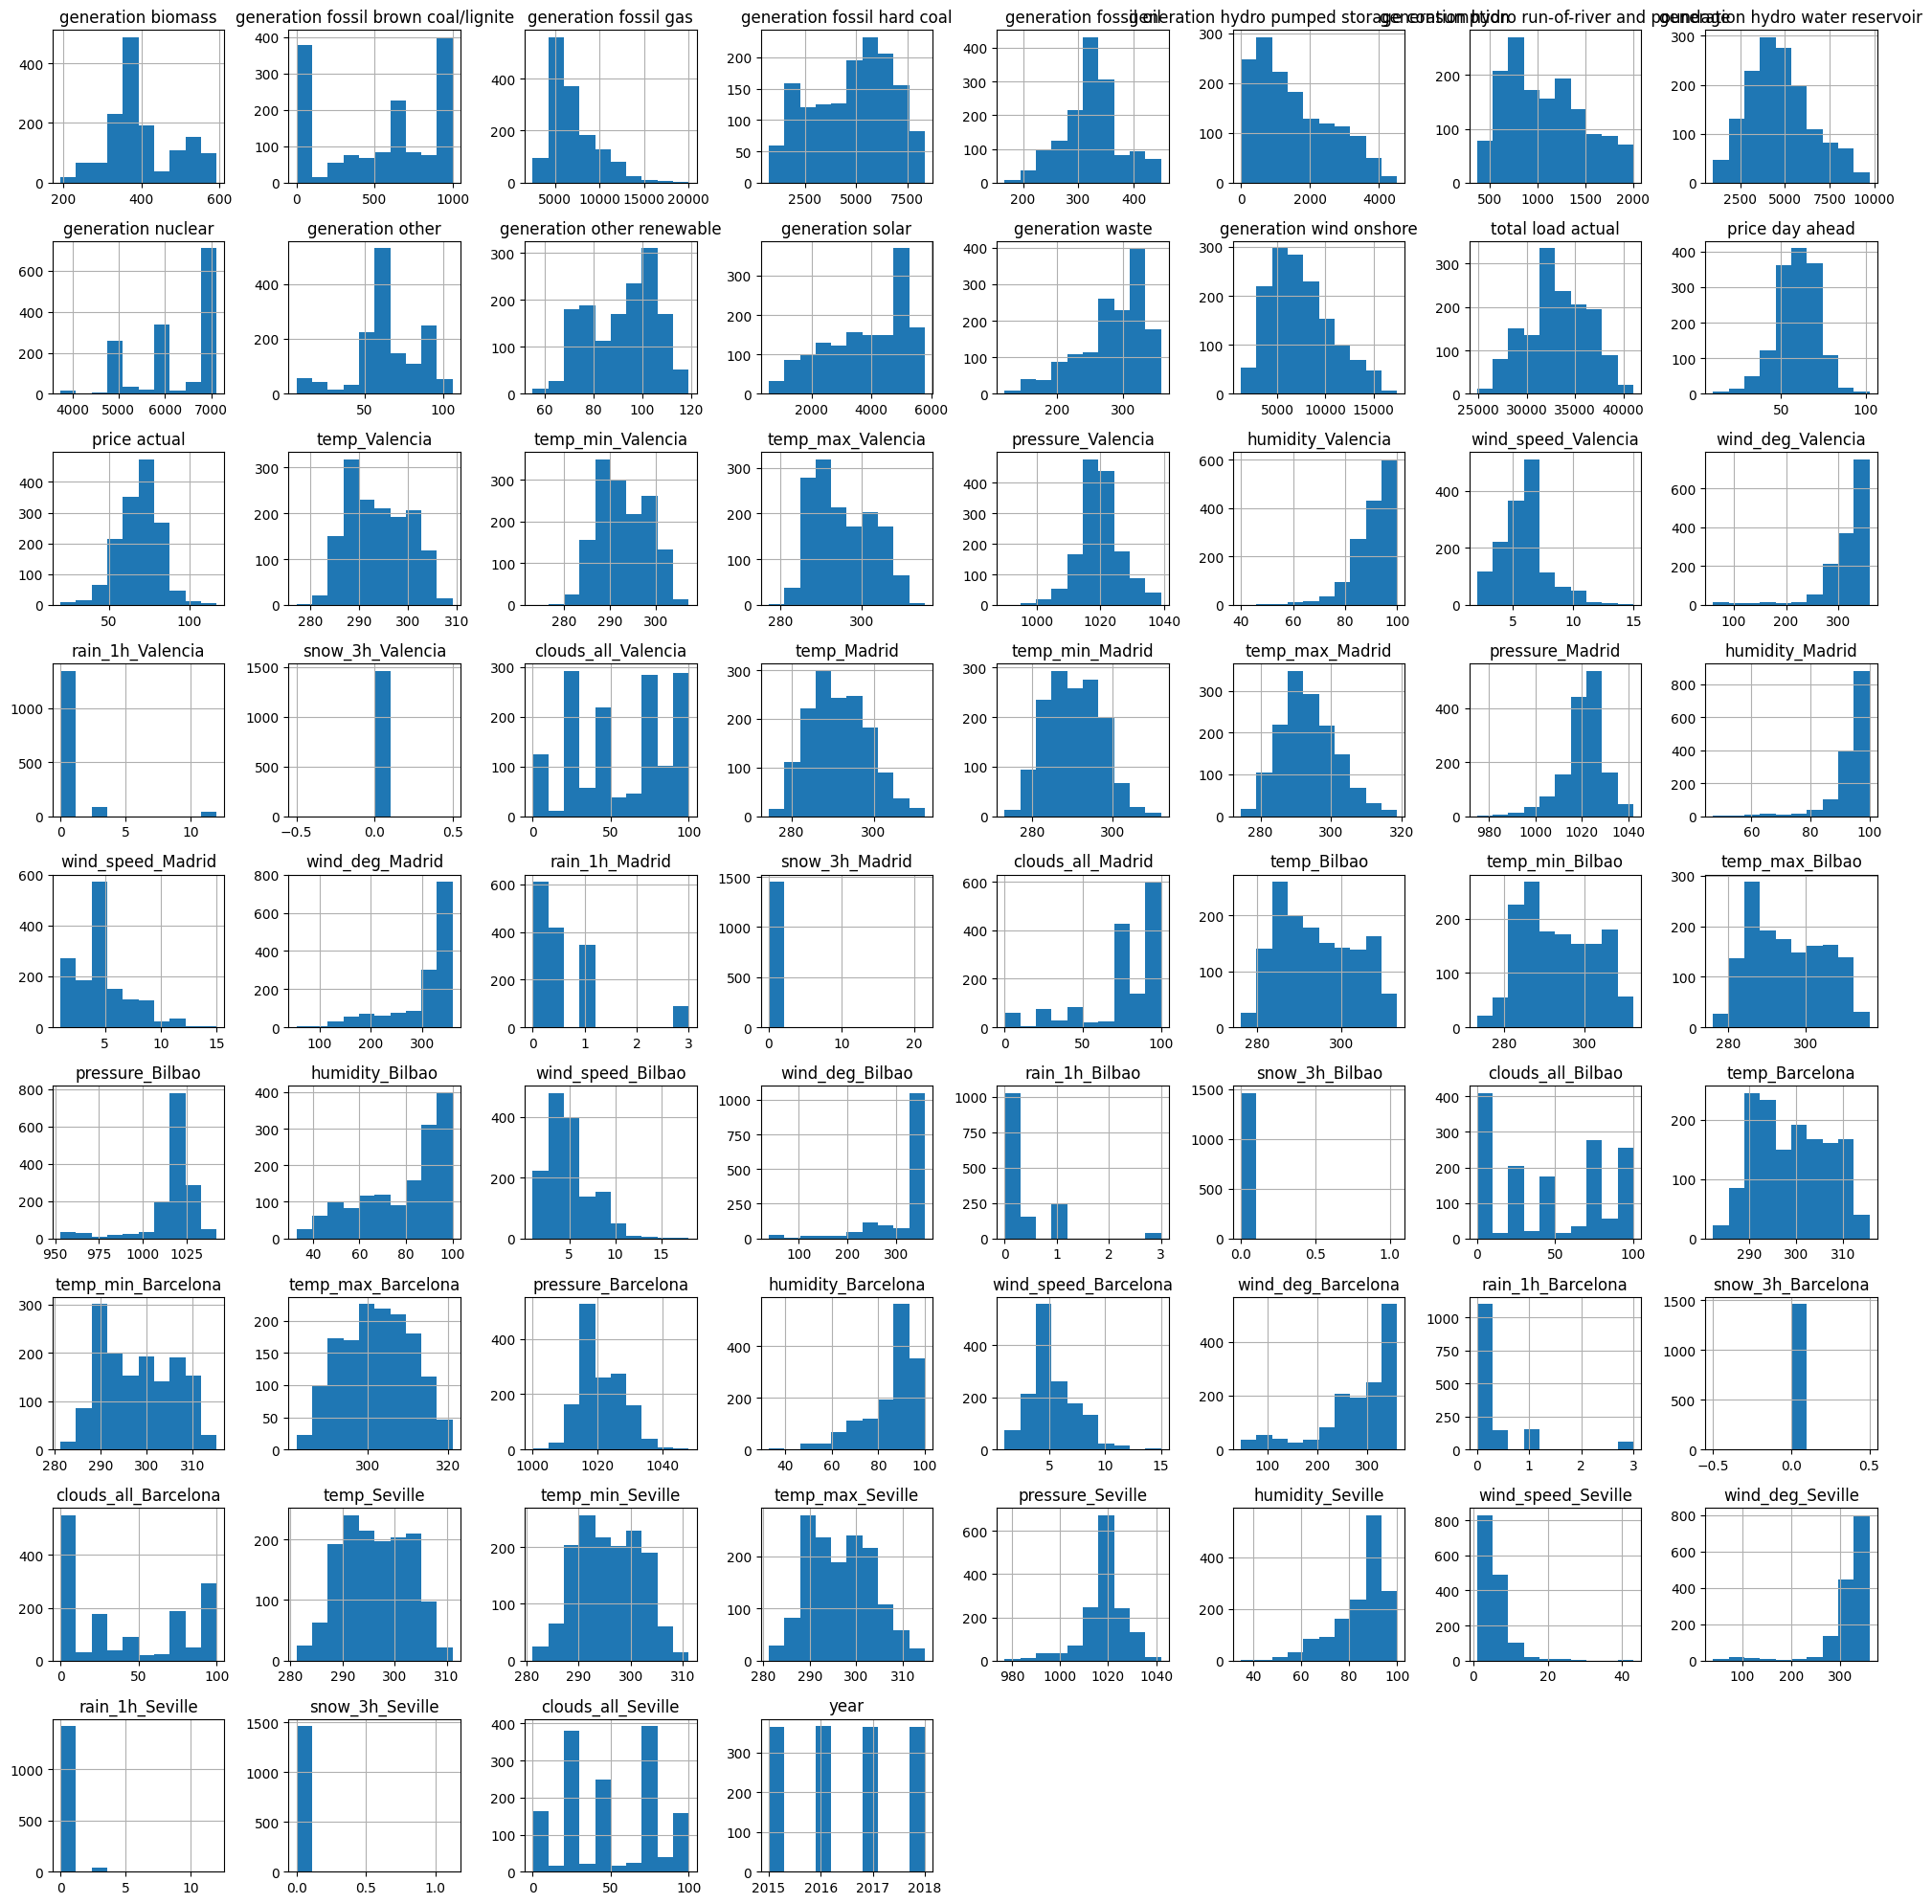

In [38]:
dataset.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

Plot heatmap for dataset to check the correlation for each features and see which feature has a strong correlation with target(price actual).  
As heatmap shown: the

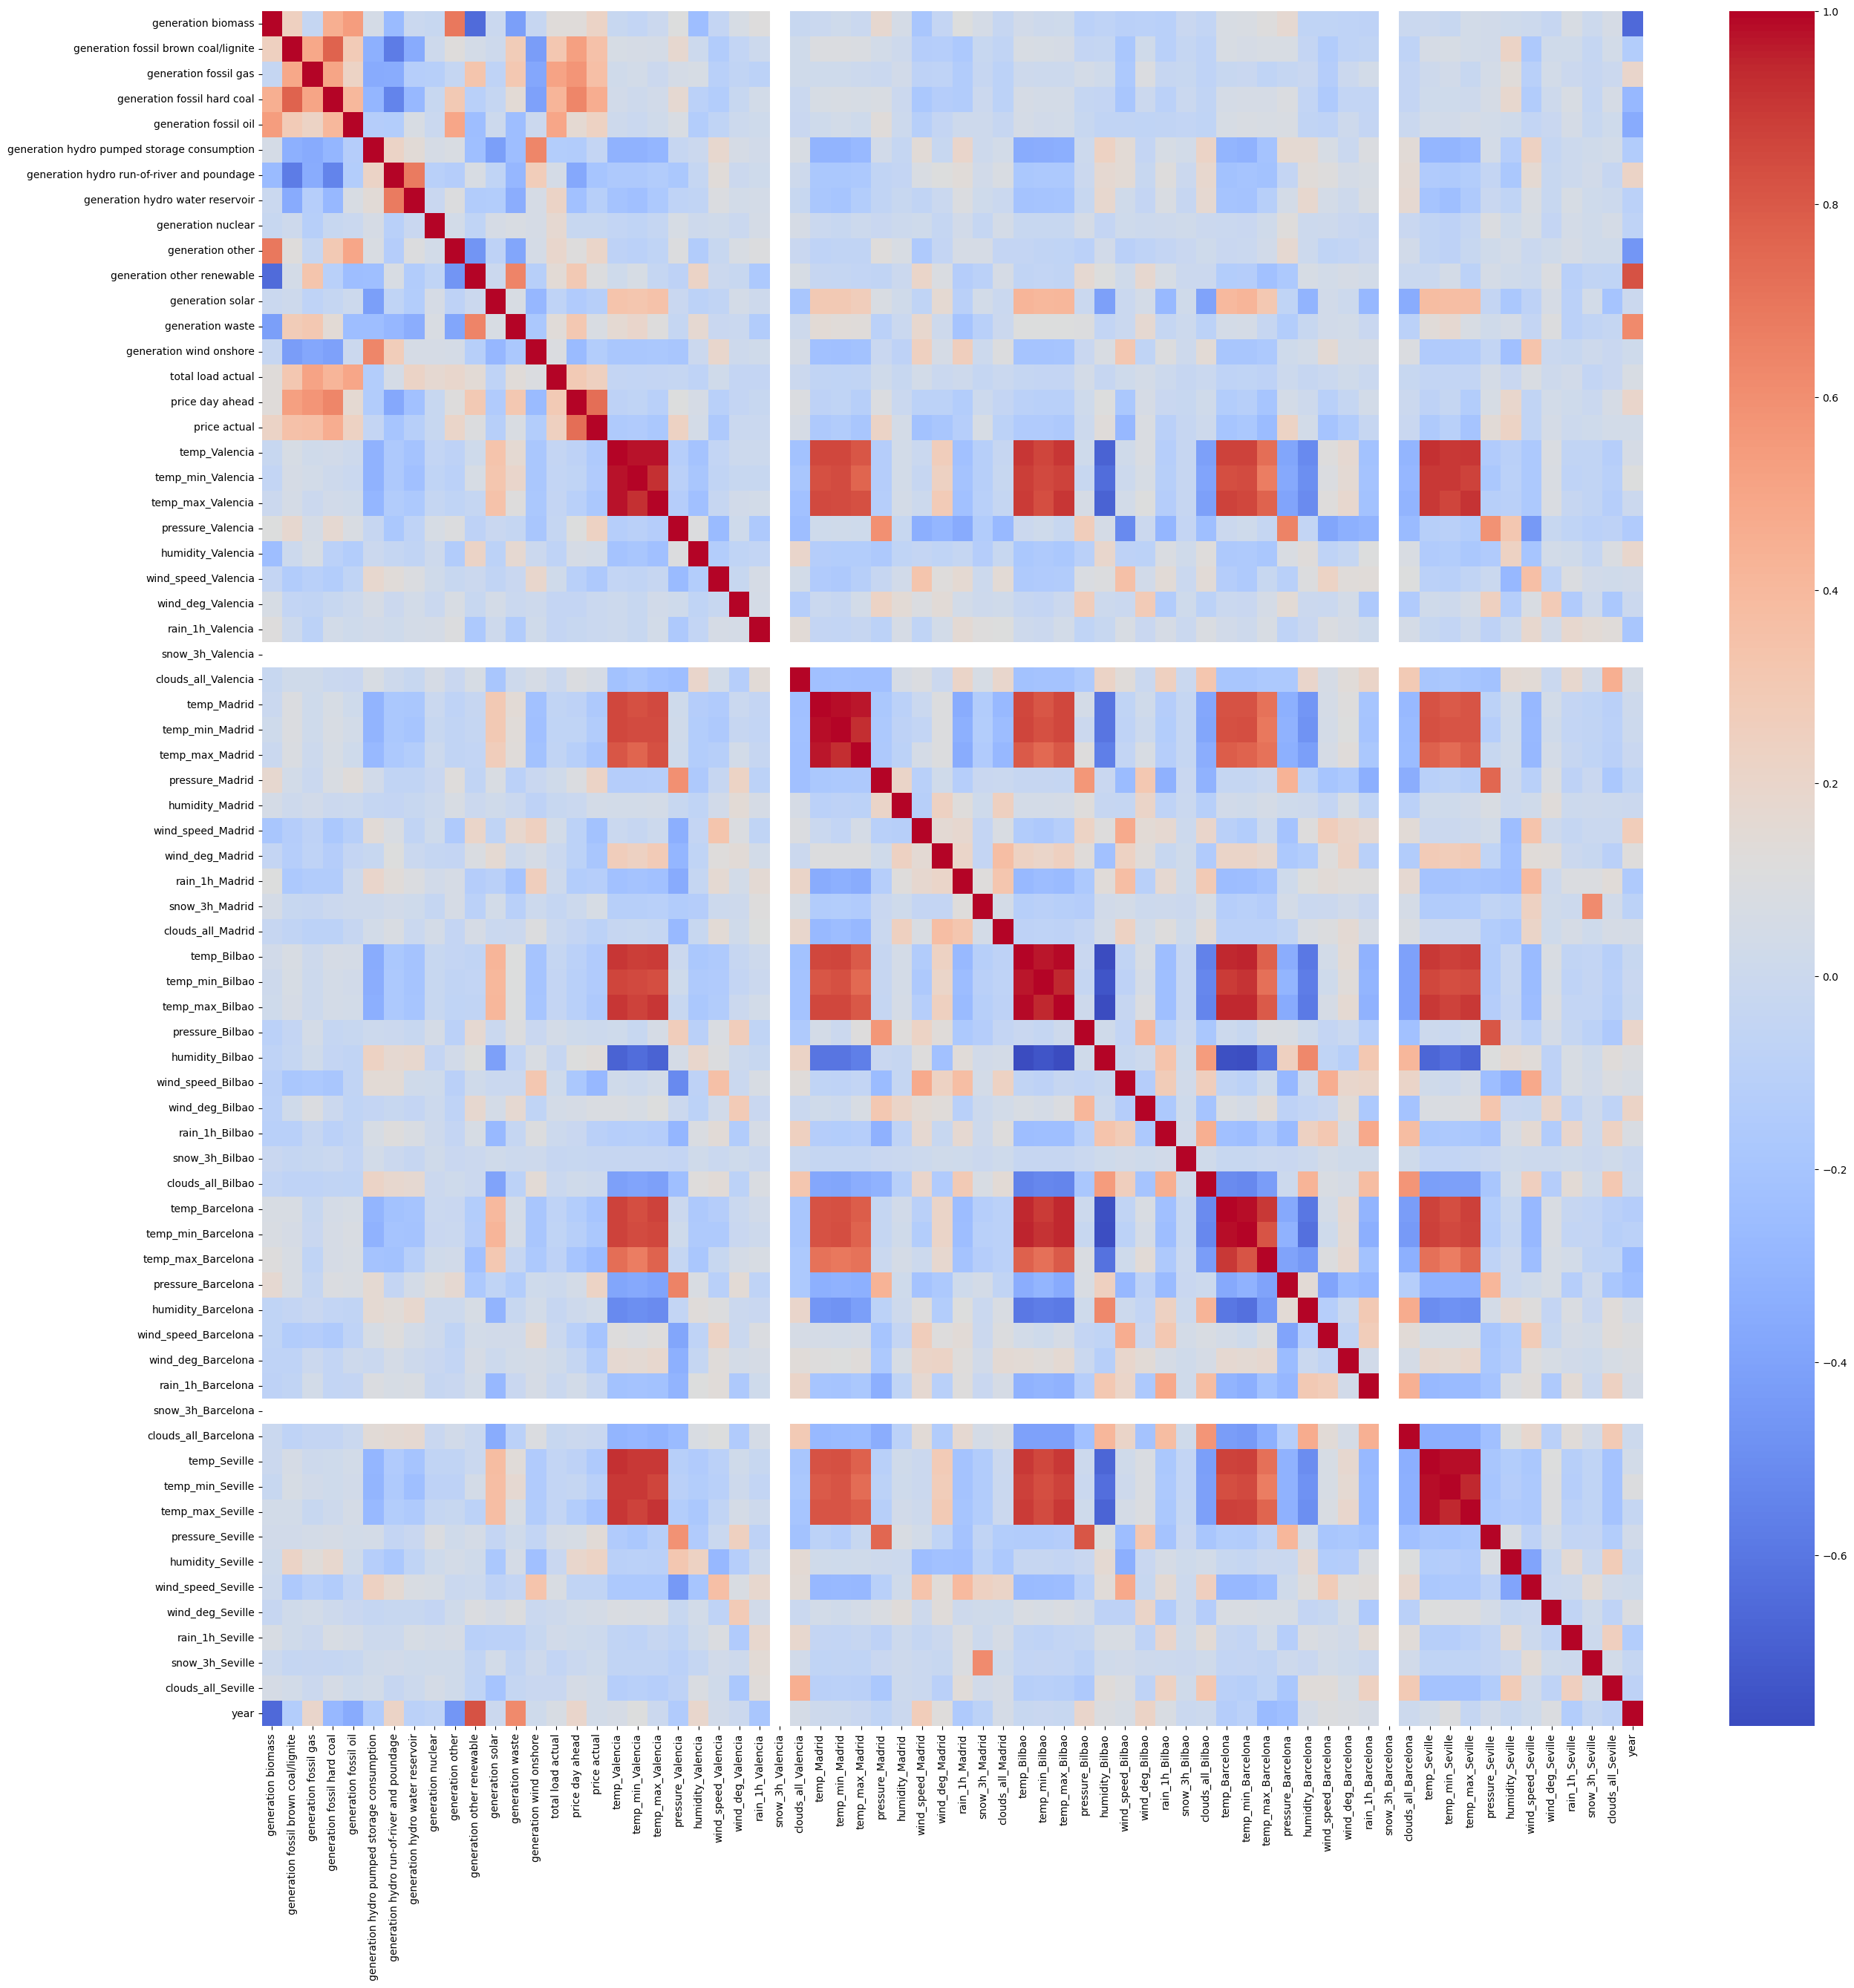

In [39]:
# Correlation matrix heatmap to visualise relationships between features
plt.figure(figsize=(30, 30))
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=False,cmap='coolwarm',fmt="g")

plt.show()

According the heatmap, we can see for snow_3h_Barcelona and snow_3h_Seville features are vacant, so drop them.

In [40]:
dataset = dataset.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

In [41]:
#dataset['generation coal all'] = dataset['generation fossil hard coal'] + dataset['generation fossil brown coal/lignite']

# PCA

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [43]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35060

In [44]:
X = dataset[dataset.columns.drop('price actual')].values
y = dataset['price actual'].values

y = y.reshape(-1, 1)

In [45]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [46]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

dataset_norm = np.concatenate((X_pca, y_norm), axis=1)
future_target = 0

In [47]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [54]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [55]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

IndexError: ignored

In [ ]:
import tensorflow as tf

batch_size = 32
buffer_size = 1000

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [ ]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

# Autocorrelation and decomposition


Autocorrelation Function and Partial Autocorrelation Function are statistical tools used in time series analysis to understand the autocorrelation structure of a time series.

> The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

ACF: each point on the autocorrelation plot represents the correlation between the series and its own lag at a specific lag number.  
As show in plot:  Positive correlation at a lag indicates a positive relationship between the observations at that lag and no negative correlation at a lag. Also we can see there is a trend on plot, then $r_{k}$(autocovariance) will not tend to zero except for very large k(lag).

PACF: measures the correlation between a time series and its lagged values, controlling for the influence of other lags. And positive partial correlation at a lag indicates a direct positive relationship between the observation and that lag and negative partial correlation at a lag indicates a direct negative relationship.  
As show in plot: positive and negative lags gradually approach zero.

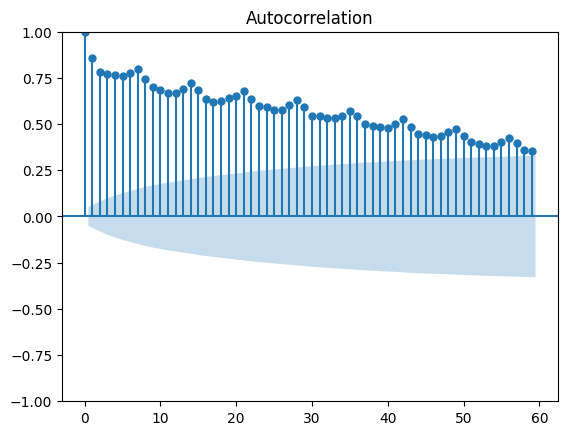

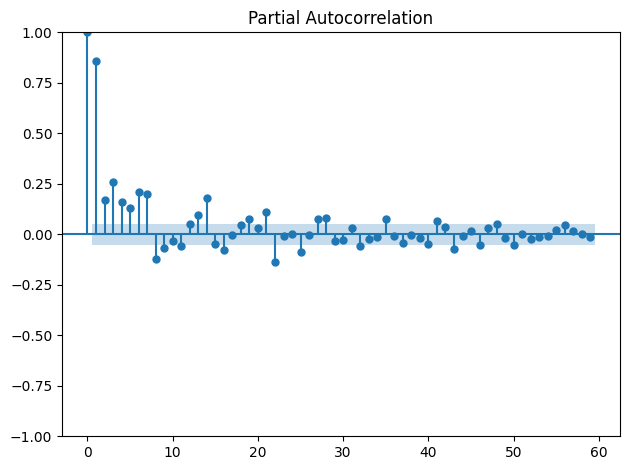

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataset['price actual'], lags=59)
plot_pacf(dataset['price actual'], lags=59)
plt.tight_layout()
plt.show()


We plot the decomposed components for target(price actual). Time series decomposition involves breaking down a time series into several components, typically including the trend, seasonality, and residuals (or irregular component).  
* Trend: shows the long-term progression of the series.  An upward trend indicates an increase over time, and a downward trend indicates a decrease.  A flat trend would suggest that the series is relatively stable over time.  

* Seasonal: Shows the regular pattern in the time series within a fixed period.  
* Residual: Mean the "noise" in the series.


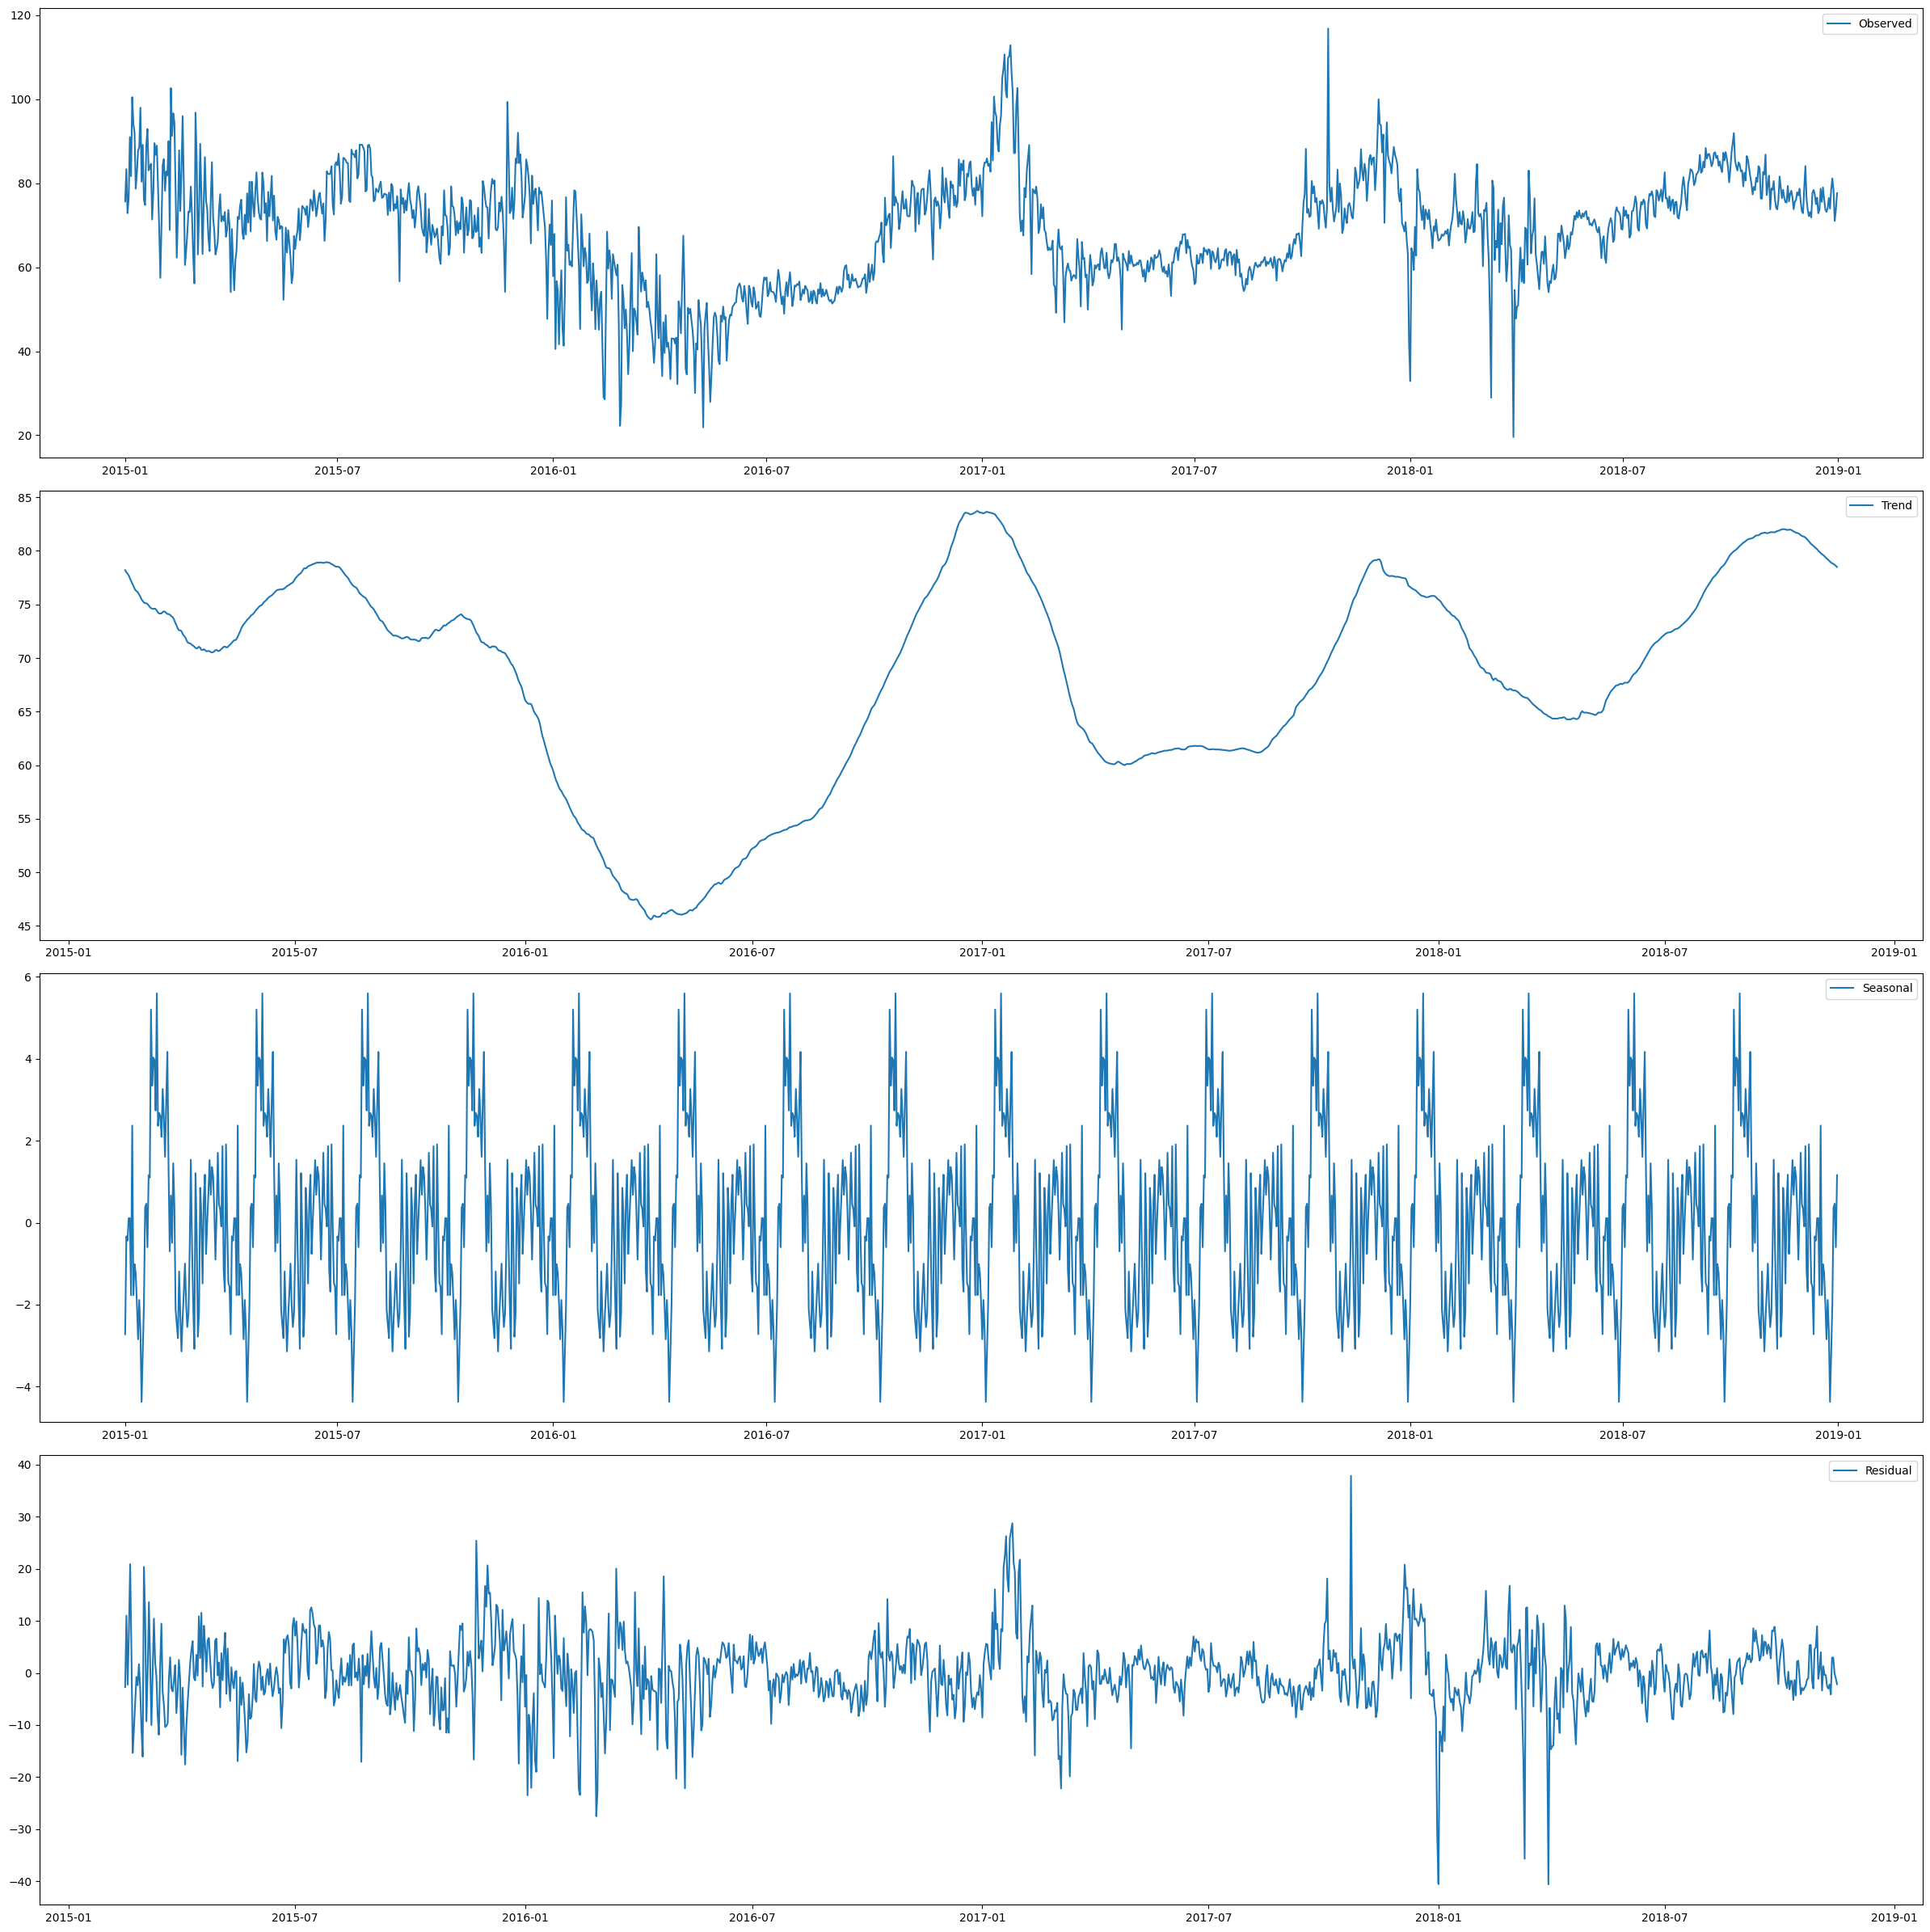

In [ ]:
# Perform decomposition
result = seasonal_decompose(dataset['price actual'], model='additive',period= 90)

# Plot the decomposed components
plt.figure(figsize=(24, 24))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


We use ADF( Augmented Dickey-Fuller) test to check for stationarity in a time series dataset, including those indexed by dates. Stationarity refers to the property of a time series having a constant mean, variance, and autocorrelation structure over time.  
**Understanding whether a time series is stationary is crucial for many time series analysis and forecasting methods, as most of these techniques assume or require stationarity.**

The ADF test is based on the concept of a unit root in a time series. A unit root is a feature of some stochastic processes that can cause issues with unpredictability and non-stationarity.  
* For Hypothesis Testing:  

The null hypothesis ($H_{0}$) is that the time series has a unit root (i.e.
γ=0), and the alternative hypothesis ($H_{1}$) is that the time series does not have a unit root (i.e.γ<0).  

Based on the estimated coefficient γ and if the test statistic is less than the critical value, rejected $H_{0}$, indicating that the time series is stationary. Source from [Augmented Dickey-Fuller (ADF) Test](https://rtmath.net/assets/docs/finmath/html/93a7b7b9-e3c3-4f19-8a57-49c3938d607d.htm)


In [ ]:
# ADF test for stationarity
result_adf = adfuller(dataset['price actual'])

print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:', result_adf[4])

if result_adf[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')


ADF Statistic: -3.00069983456643
p-value: 0.03482909619884808
Critical Values: {'1%': -3.434911997169608, '5%': -2.863554810504947, '10%': -2.567842671398422}
The time series is likely stationary.


Reading the output, the ADF statistic (-3.001) is more negative than the critical value at the 5% level (-2.8636) and the p-value (0.035) is less than 0.05, we have enough evidence to **reject the null hypothesis at the 5% significance level**. This means we can conclude with a reasonable degree of confidence that the time series is stationary.

## Data scaling


After seperating the features and the target, we normalise the data using Min-Max scaling. The purpose of normalization is to bring all features to a similar scale, typically between 0 and 1, so that the model can learn more effectively and converge faster during training. It can avoid numerical instabilities and be a better generalisation.

In [ ]:
# # Extract features and target variable

price_actual = df_energy.filter(["price actual"]) # Assuming 'price_actual' is target variable

features = dataset.drop(['price actual'], axis=1)

df_price = price_actual.values


In [ ]:
# # Scale features and to the range [0, 1]
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))

df_scaled = feature_scaler.fit_transform(features)

price_scaled = target_scaler.fit_transform(df_price)

# Train/Test split

Splitting the data set into train and test sets using random shuffling and sampling works well for independent and identically distributed (i.i.d) data sets. However, this is not appropriate for time series data since the order of each observation matters. Future observations depend on past observations and splitting the data randomly can lead to information leakage, as future data might end up in the training set.

Therefore, we split the data based on a specific time point i.e. we take the first 80% of days as the train set and the remaining 20% as the test set.

In [ ]:
def timeseries_split(X, y, test_size=0.2, random_state = 42):
  np.random.seed(random_state)

  tr_len = math.ceil(len(X)*(1-test_size))
  training_data = X[0:tr_len]

  X_train = []
  y_train = []

  k = 60 # number of previous observations to predict next one

  for i in range(k, len(training_data)):
      # In each pass, the first k observations are added to X_train,  the k+1th observation is added to y_train

      X_train.append(training_data[i-k:i, 0])
      y_train.append(training_data[i, 0])

  test_data = X[tr_len - k:, :]

  X_test = []
  y_test = y[tr_len: , :]

  for i in range(k, len(test_data)):
    X_test.append(test_data[i-k:i, 0])

  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
test_size = 0.2
tr_len = math.ceil(len(df_scaled)*(1-test_size))

X_train, X_test, y_train, y_test = timeseries_split(df_scaled, df_price, test_size = test_size, random_state = 42 )

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

X_train.shape, X_test.shape , y_train.shape, y_test.shape


((1109, 60, 1), (292, 60, 1), (1109,), (292, 1))

 # Neural Network models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [ ]:
def plotPredictions(model):
  plt.figure(figsize=(30, 20))
  plt.plot(y_test, label='Actual Values')
  plt.plot(model, label='Predictions', linestyle='--')
  plt.xlabel("Date")
  plt.ylabel("Maximum Daily Price (EUR)")
  plt.legend()
  plt.show()

In [ ]:
optimizer = Adam(learning_rate=6e-3, amsgrad=True)
loss = MeanSquaredError()
metric = [RootMeanSquaredError(), 'mae']

input_shape = X_train.shape[-2:]
lr_schedule = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = EarlyStopping(patience=10)

## LSTM

In [ ]:
lstm = Sequential([
    LSTM(100, input_shape=input_shape, return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = ModelCheckpoint('lstm.h5', monitor=('val_loss'), save_best_only=True)
lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

In [ ]:
lstm_history = lstm.fit(train, epochs=20,  validation_data=validation,
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
845/845 [==============================] - 30s 36ms/step - loss: 0.0044 - root_mean_squared_error: 0.0666 - mae: 0.0501 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612 - val_mae: 0.0474
Epoch 2/20
845/845 [==============================] - 27s 32ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - mae: 0.0390 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592 - val_mae: 0.0474
Epoch 3/20
845/845 [==============================] - 29s 34ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - mae: 0.0338 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0430 - val_mae: 0.0331
Epoch 4/20
845/845 [==============================] - 27s 32ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - mae: 0.0311 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373 - val_mae: 0.0283
Epoch 5/20
845/845 [==============================] - 30s 35ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - mae: 0.0272 - val_loss: 0.0015 - val_root_mean_squared_er

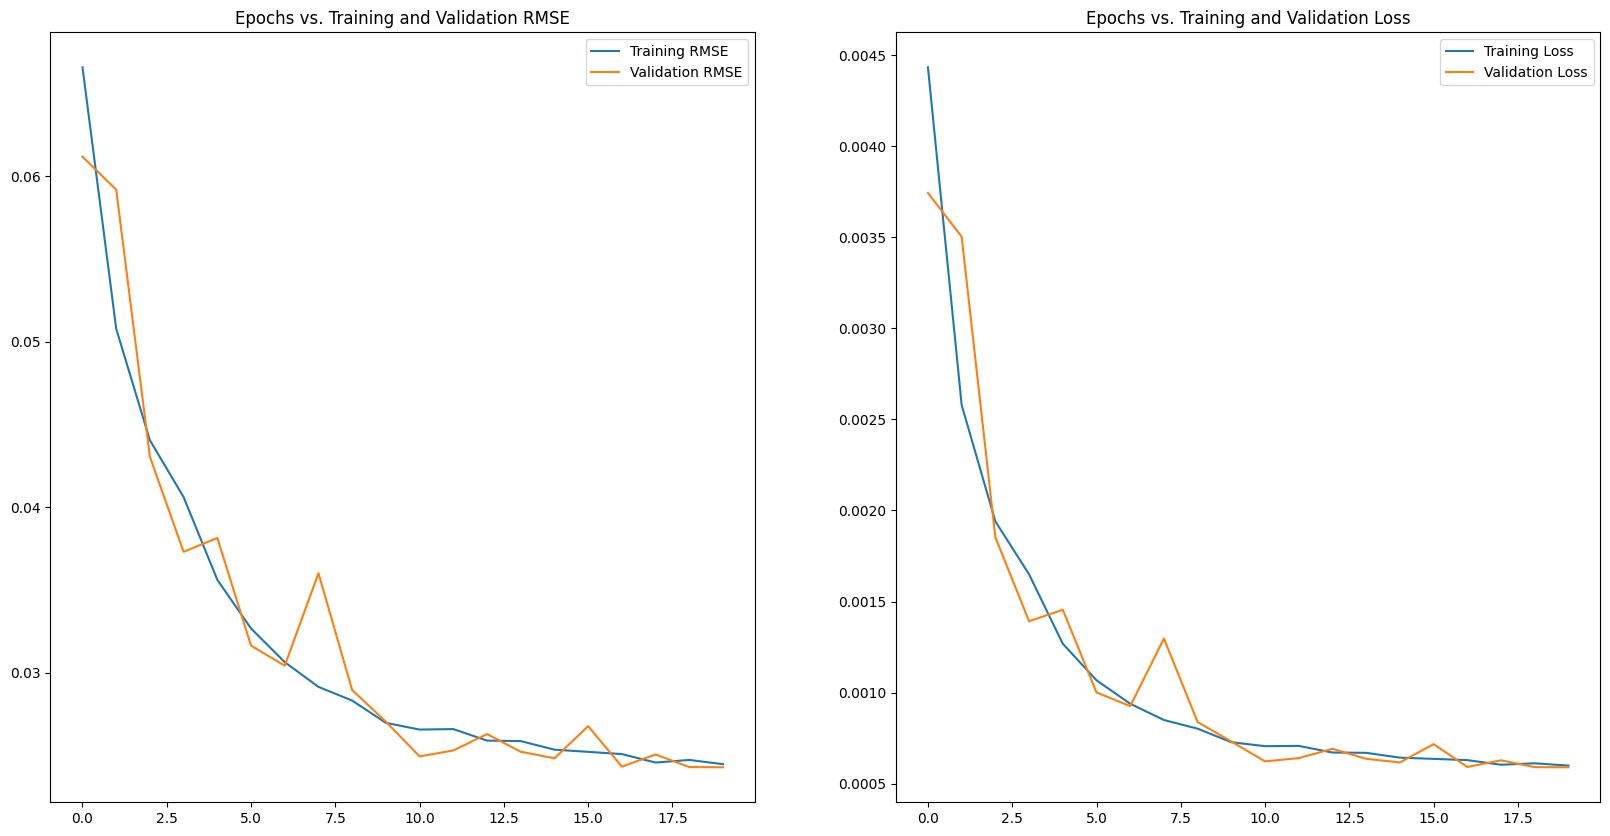

In [ ]:
plot_model_rmse_and_loss(lstm_history)

In [ ]:
lstm = tf.keras.models.load_model('lstm.h5')
pred_lstm = lstm.predict(X_test)
rmse_lstm = sqrt(mean_squared_error(y_test_inv, scaler_y.inverse_transform(pred_lstm)))

print(f'RMSE of hour-ahead electricity price LSTM forecast: {round(rmse_lstm, 3)}')

125/125 [==============================] - 3s 14ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.268


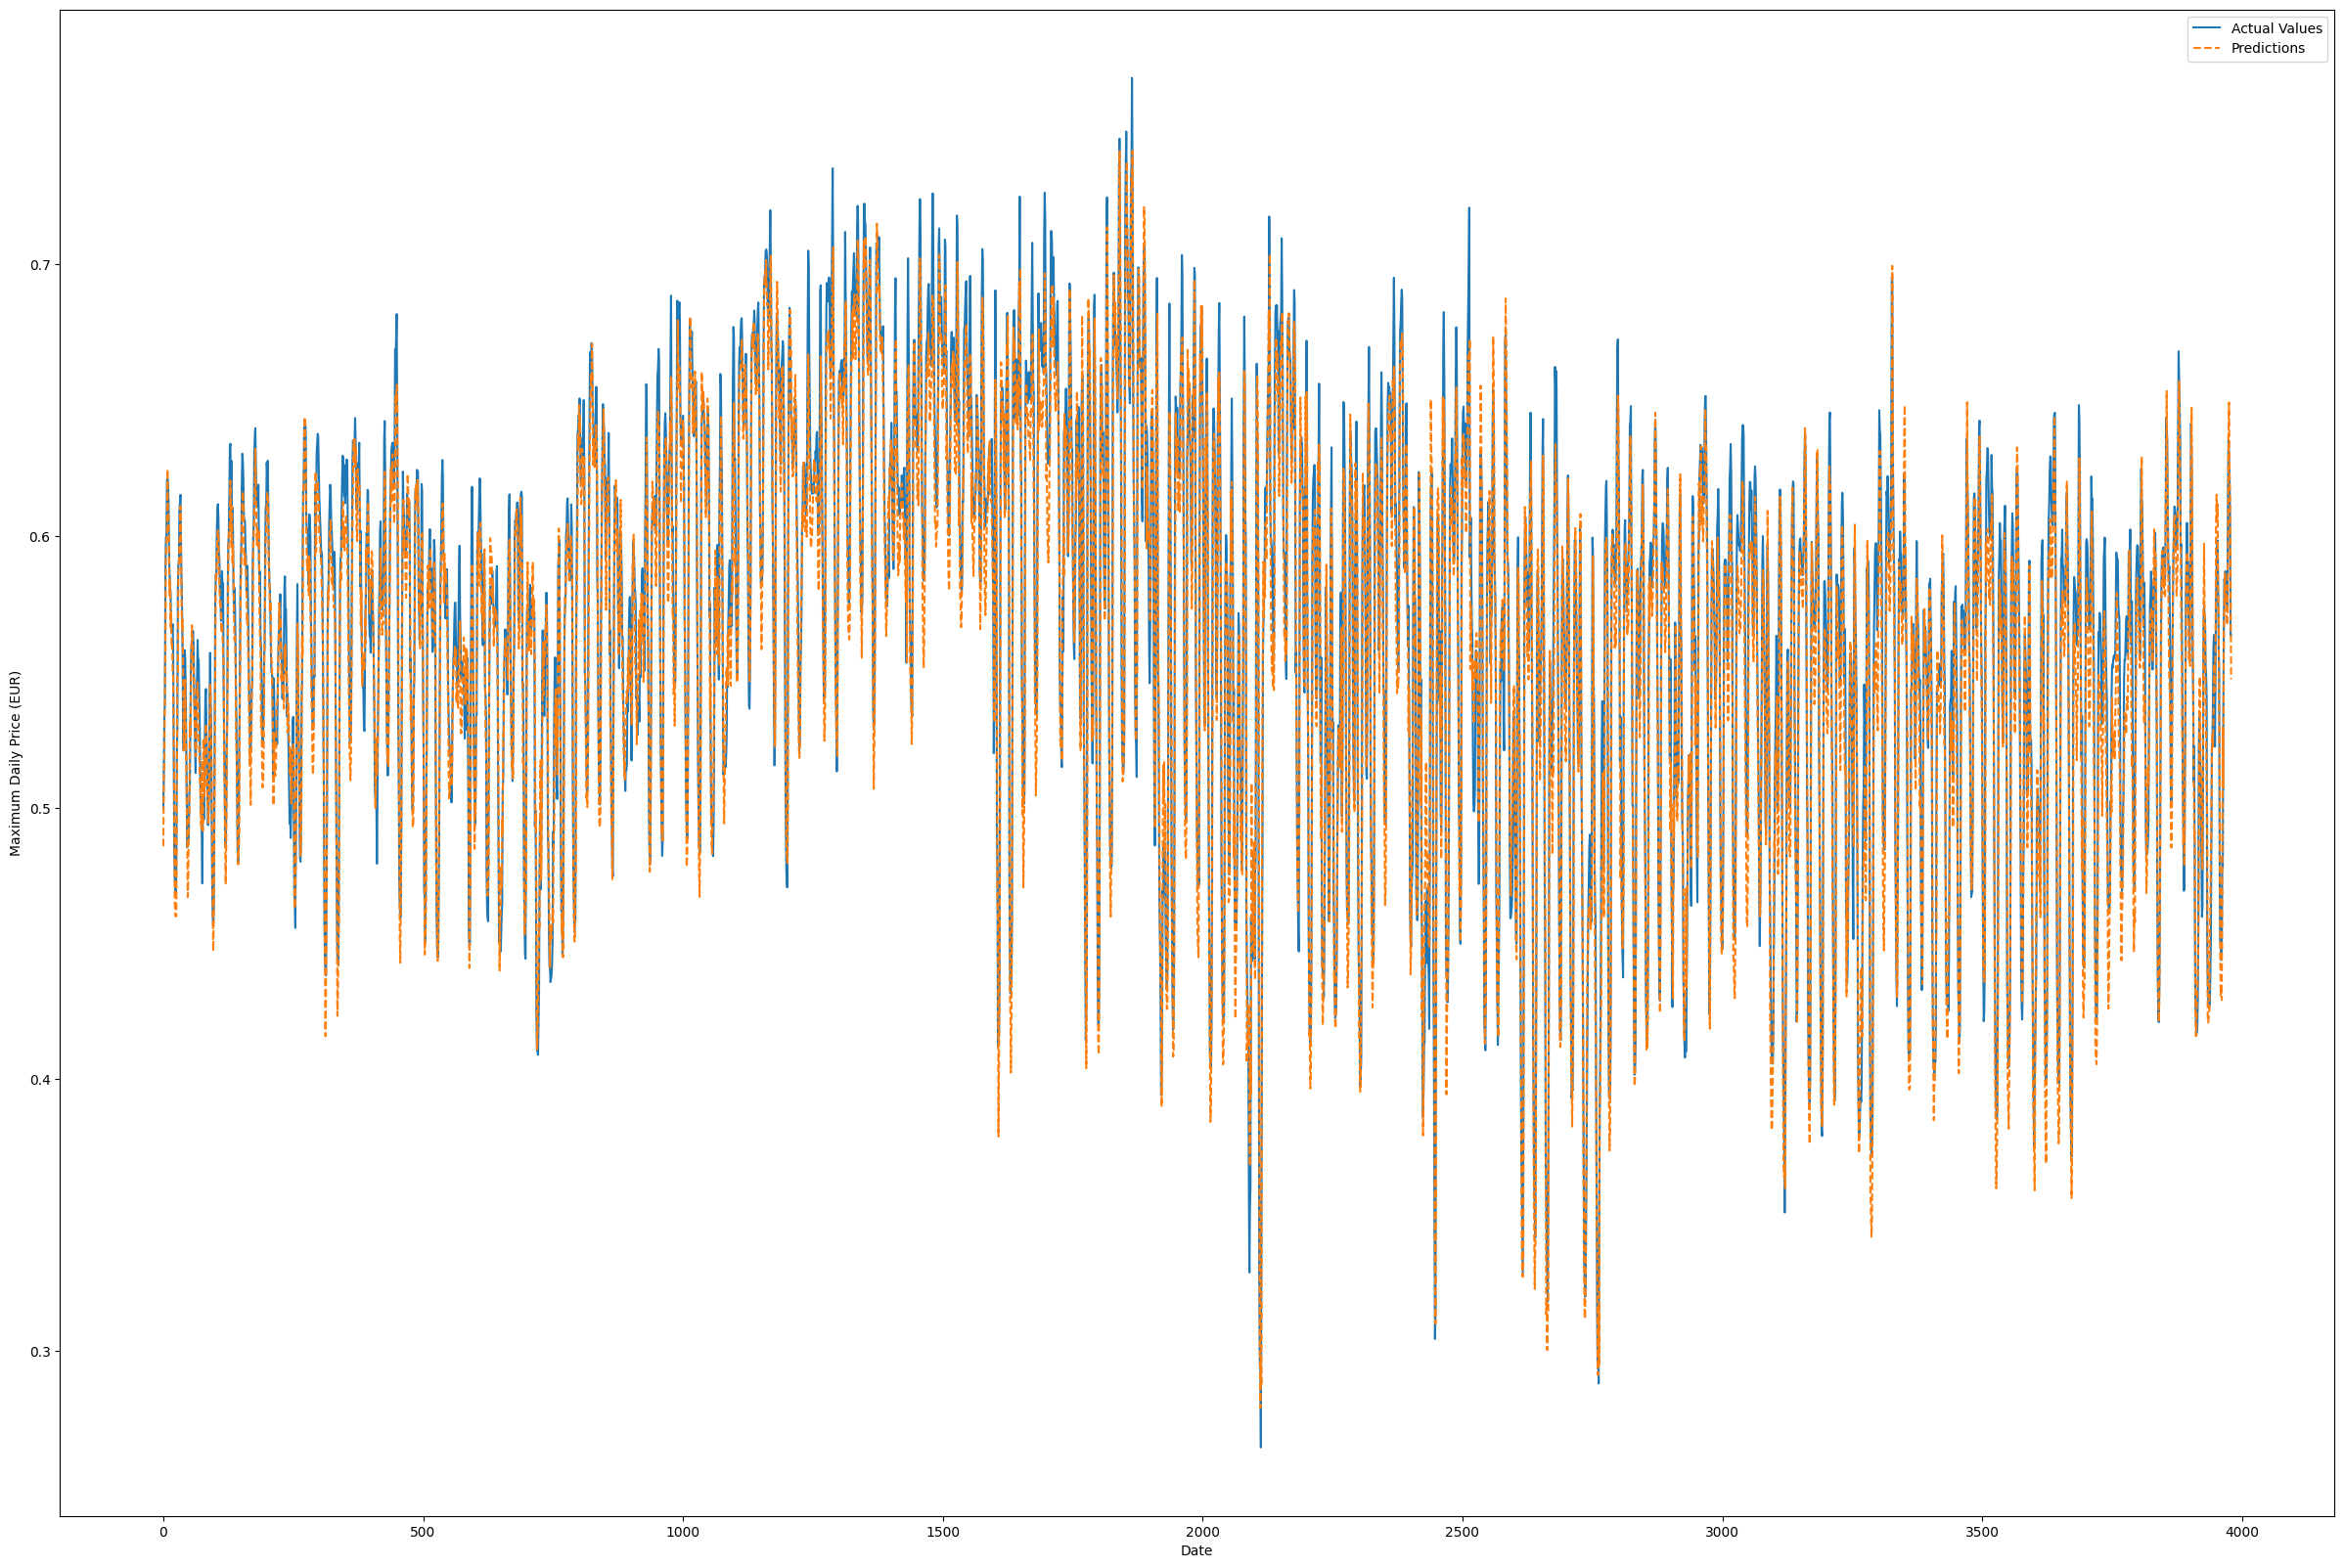

In [ ]:
plotPredictions(pred_lstm)

(3980, 1) (3980,)


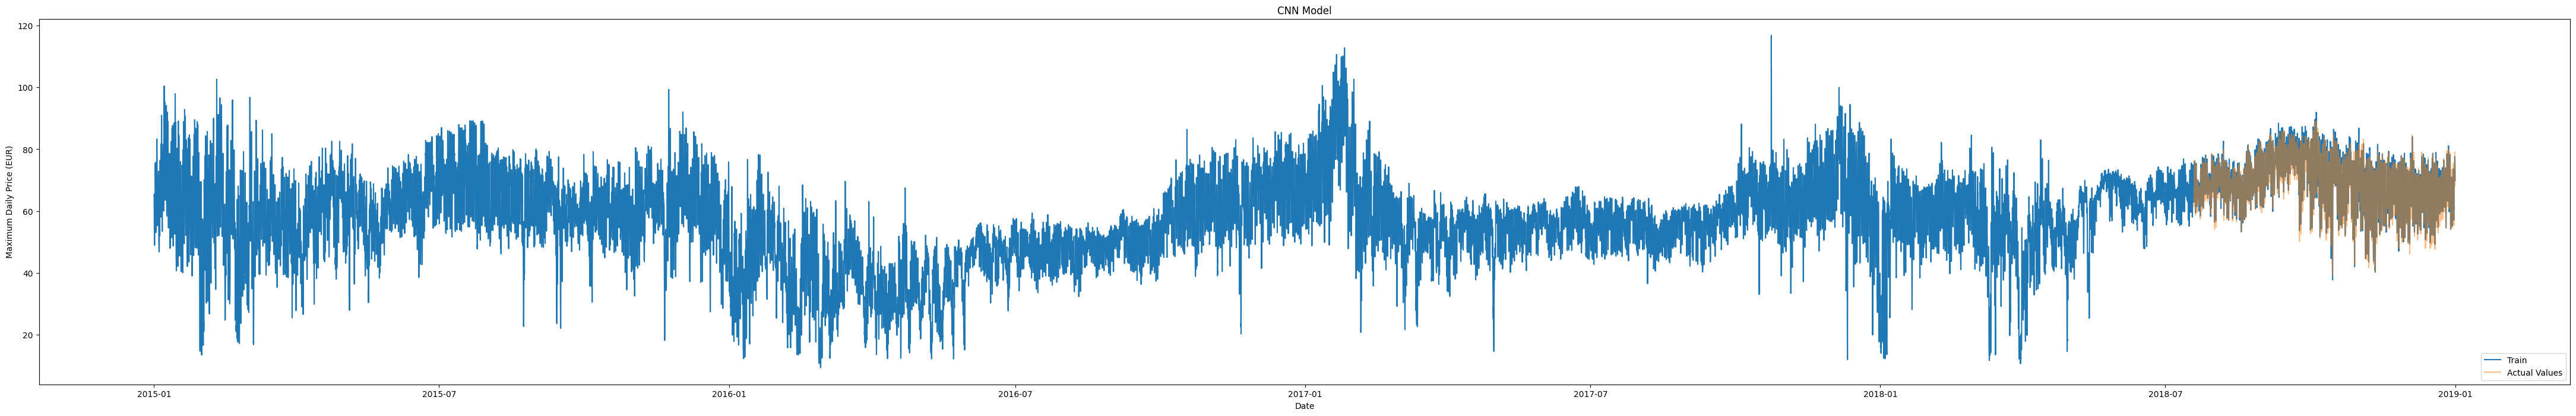

In [ ]:
# plot predictions

valid = scaler_y.inverse_transform(pred_lstm)
print(valid.shape, dataset.index[cv_end_idx+24:].shape)
new = pd.DataFrame(data=valid, index=dataset.index[cv_end_idx+24:])

plt.figure(figsize = (55,8))
plt.title("CNN Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(dataset[["price actual"]])
plt.plot(new, alpha=0.5)
plt.legend(["Train", "Actual Values", "Predictions"], loc="lower right")
plt.show()

## CNN

Convolutional neural networks (CNN) originated from the study of the visual cortex of the brain and have been used in image recognition since the 1980s.Up to now, CNN has widely used in image search services, autonomous vehicles, automatic video classification systems, etc.

1D CNNs work with one-dimensional data, is particularly well-suited for processing sequential data such as time series, audio signals, and text.

The structure for 1D CNN include(as shown in figure 3):
* Convolutional Layer:

It's the core building block of a CNN and consists of a set of learnable filters or kernels.
This process is capable of extracting high-level features from the data like the trends or patterns in time series.
* Activation Function:

After convolution, an activation function is applied. I choice Rectified Linear Unit (like apply code:`activation='relu'`), introducing non-linearity into the model, allowing it to learn more complex patterns.
* Pooling Layer:

Pooling layers are used to reduce the dimensions of the feature maps. In 1D CNNs, pooling is typically done along the time axis (or the sequence length), and I used `MaxPooling1D(pool_size=2)`, where the maximum value over a window is taken.
* Fully Connected Layer:

The high-level reasoning in the neural network is done through fully connected layers. In these layers, neurons have full connections to all activations in the previous layer.
* Output Layer:

The final layer is tailored to the specific task and it outputs the predictions of the model.  


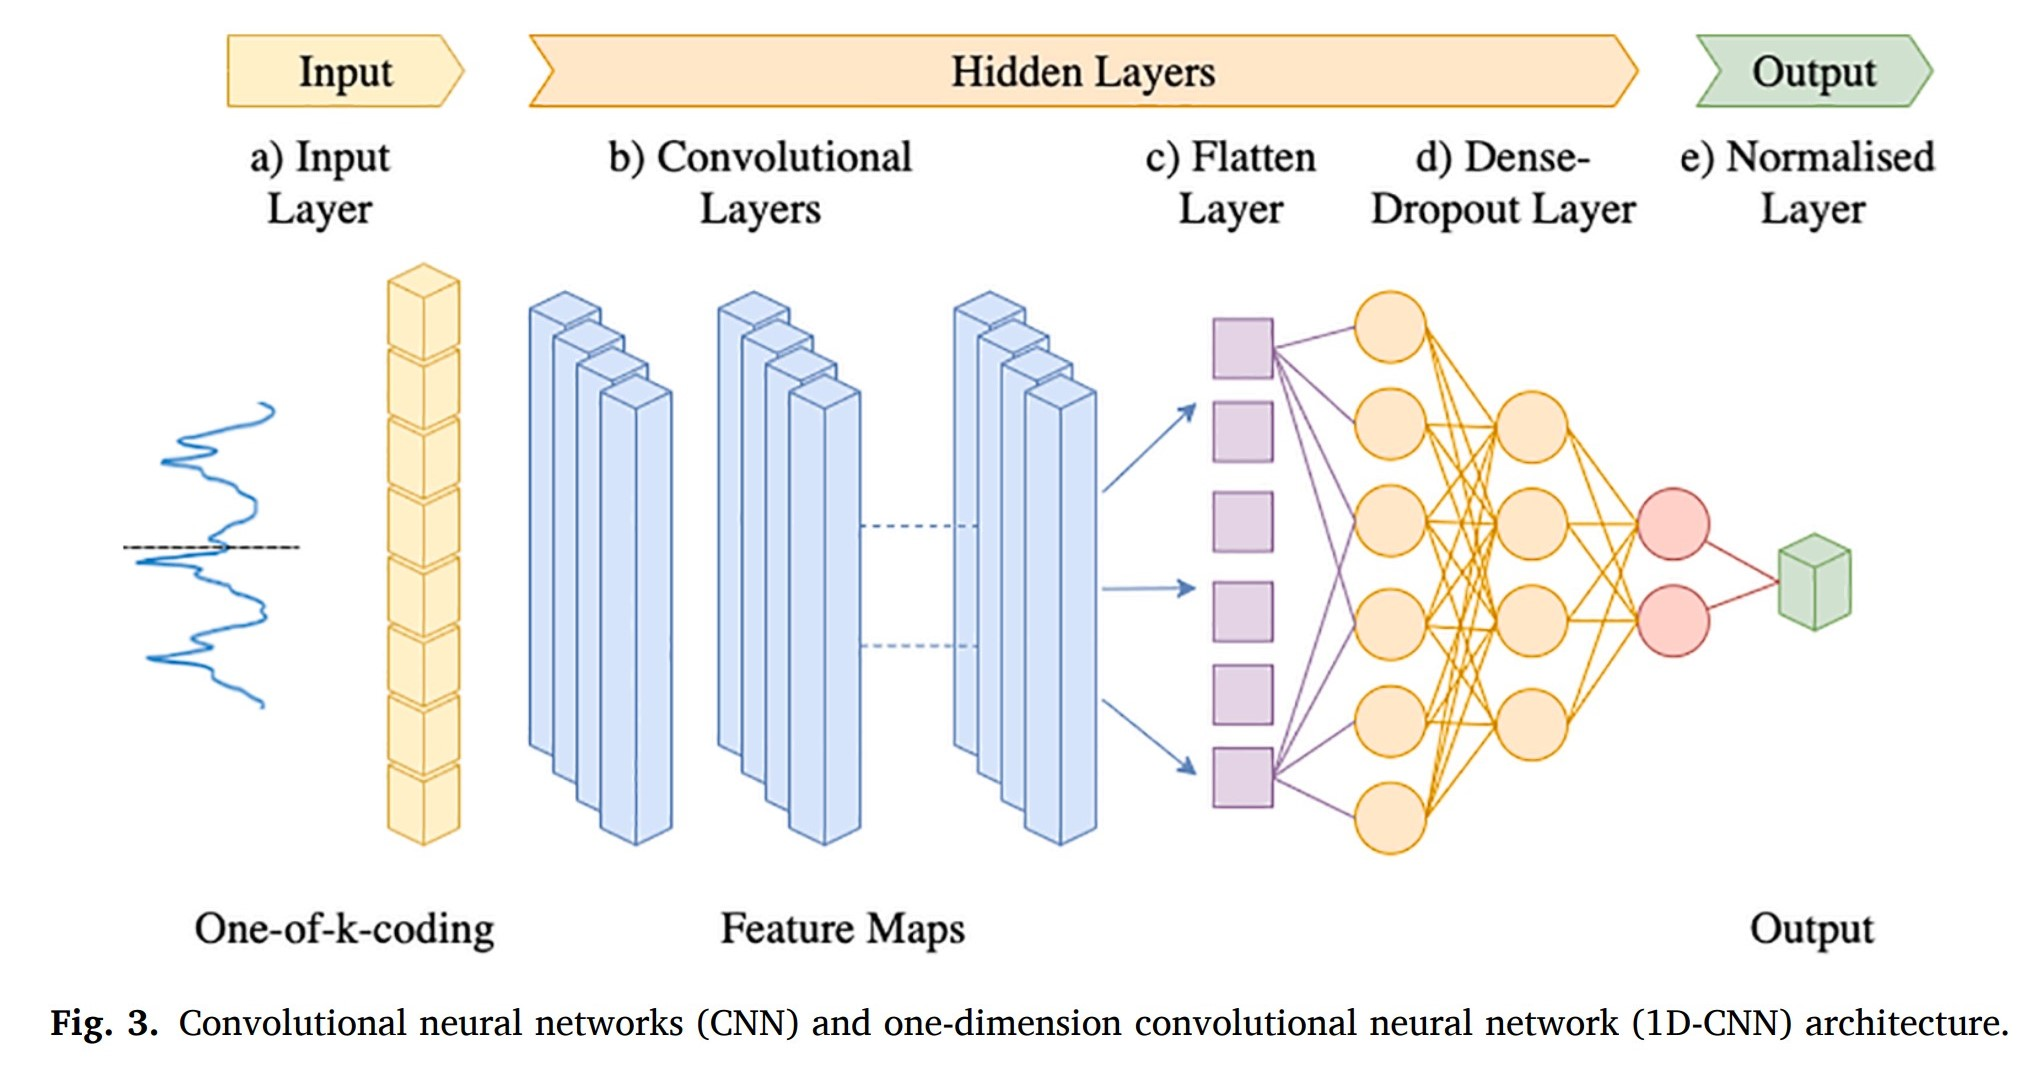

Definition Reference:[One-dimensional convolutional neural networks for low/high arousal classification from electrodermal activity](https://www.sciencedirect.com/science/article/pii/S1746809421008004), [Hands-on Machine Learning with
Scikit-Learn, Keras, and
TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

In [ ]:
# Reshape the data to fit the expected input shape for a 1D CNN
X_train_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_CNN = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
#cnn_model = Sequential([
    # Convolution
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    # Pooling
    MaxPooling1D(pool_size=2),
    # Flatten the layer
    Flatten(),
    # Fully Connected Layers
    Dense(50, activation='relu'),
    # Linear activation for regression
    Dense(1, activation='linear')
])
#model_checkpoint_cnn = ModelCheckpoint('cnn.h5', monitor=('val_loss'), save_best_only=True)
# Compile the model
#cnn_model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
model = Sequential()
# Convolution
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# Pooling
model.add(MaxPooling1D(pool_size=2))
# Flatten the layer
model.add(Flatten())
# Fully Connected Layers
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
model.fit(X_train_CNN, y_train, epochs=10, batch_size=32, validation_data=(X_test_CNN, y_test))

Epoch 1/10
35/35 [==============================] - 1s 7ms/step - loss: 0.0700 - mae: 0.1850 - val_loss: 5448.1753 - val_mae: 73.2865
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0211 - mae: 0.1058 - val_loss: 5452.2148 - val_mae: 73.3140
Epoch 3/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0195 - mae: 0.1029 - val_loss: 5450.1943 - val_mae: 73.3003
Epoch 4/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0182 - mae: 0.0996 - val_loss: 5449.0674 - val_mae: 73.2927
Epoch 5/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0161 - mae: 0.0934 - val_loss: 5451.2412 - val_mae: 73.3076
Epoch 6/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0142 - mae: 0.0886 - val_loss: 5452.3198 - val_mae: 73.3150
Epoch 7/10
35/35 [==============================] - 0s 3ms/step - loss: 0.0130 - mae: 0.0845 - val_loss: 5452.4512 - val_mae: 73.3159
Epoch 8/10
35/35 [==============================] - 0s 3ms/ste

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 928)               0         
                                                                 
 dense (Dense)               (None, 50)                46450     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 46629 (182.14 KB)
Trainable params: 46629 (182.14 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
predictions_CNN = model.predict(X_test_CNN)

10/10 [==============================] - 0s 3ms/step


In [ ]:
#predictions_CNN = predictions_CNN.reshape(predictions_CNN.shape[0], -1)
predictions_CNN = target_scaler.inverse_transform(predictions_CNN)

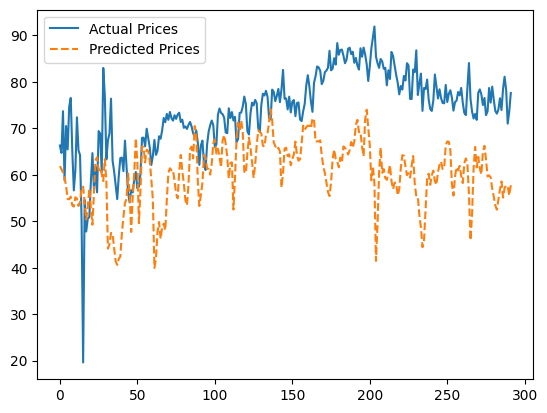

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual Prices')
plt.plot(predictions_CNN, label='Predicted Prices', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# plot predictions
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = predictions_CNN


plt.figure(figsize = (16,8))
plt.title("TSMixer Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [ ]:
# Train the model
#cnn_history = cnn_model.fit(train, epochs=14,  validation_data=validation,
                            callbacks=[model_checkpoint])

Epoch 1/14
845/845 [==============================] - 5s 6ms/step - loss: 5.1131e-04 - root_mean_squared_error: 0.0226 - mae: 0.0171 - val_loss: 8.3546e-04 - val_root_mean_squared_error: 0.0289 - val_mae: 0.0210
Epoch 2/14
845/845 [==============================] - 4s 4ms/step - loss: 5.0977e-04 - root_mean_squared_error: 0.0226 - mae: 0.0171 - val_loss: 8.5103e-04 - val_root_mean_squared_error: 0.0292 - val_mae: 0.0214
Epoch 3/14
845/845 [==============================] - 3s 4ms/step - loss: 5.0489e-04 - root_mean_squared_error: 0.0225 - mae: 0.0170 - val_loss: 8.5134e-04 - val_root_mean_squared_error: 0.0292 - val_mae: 0.0212
Epoch 4/14
845/845 [==============================] - 3s 4ms/step - loss: 5.0332e-04 - root_mean_squared_error: 0.0224 - mae: 0.0170 - val_loss: 8.8620e-04 - val_root_mean_squared_error: 0.0298 - val_mae: 0.0216
Epoch 5/14
845/845 [==============================] - 4s 5ms/step - loss: 4.9417e-04 - root_mean_squared_error: 0.0222 - mae: 0.0169 - val_loss: 8.9036e

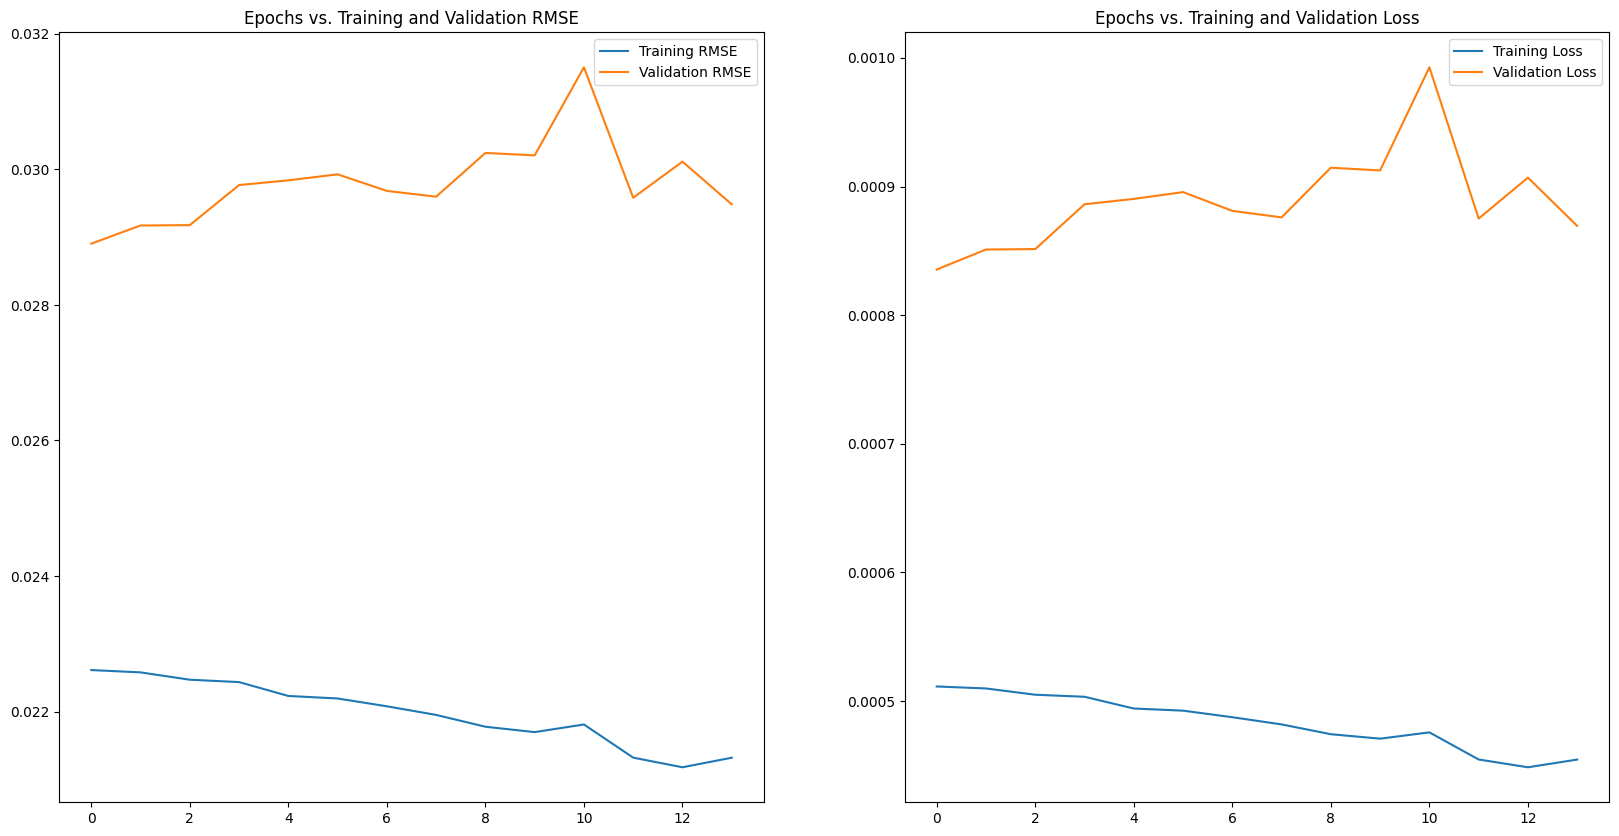

In [ ]:
plot_model_rmse_and_loss(cnn_history)

In [ ]:
cnn = tf.keras.models.load_model('cnn.h5')
pred_cnn = cnn.predict(X_test)
rmse_cnn = sqrt(mean_squared_error(y_test_inv, scaler_y.inverse_transform(pred_cnn)))

print(f'RMSE of hour-ahead electricity price CNN forecast: {round(rmse_cnn, 3)}')

125/125 [==============================] - 1s 3ms/step
RMSE of hour-ahead electricity price CNN forecast: 2.617


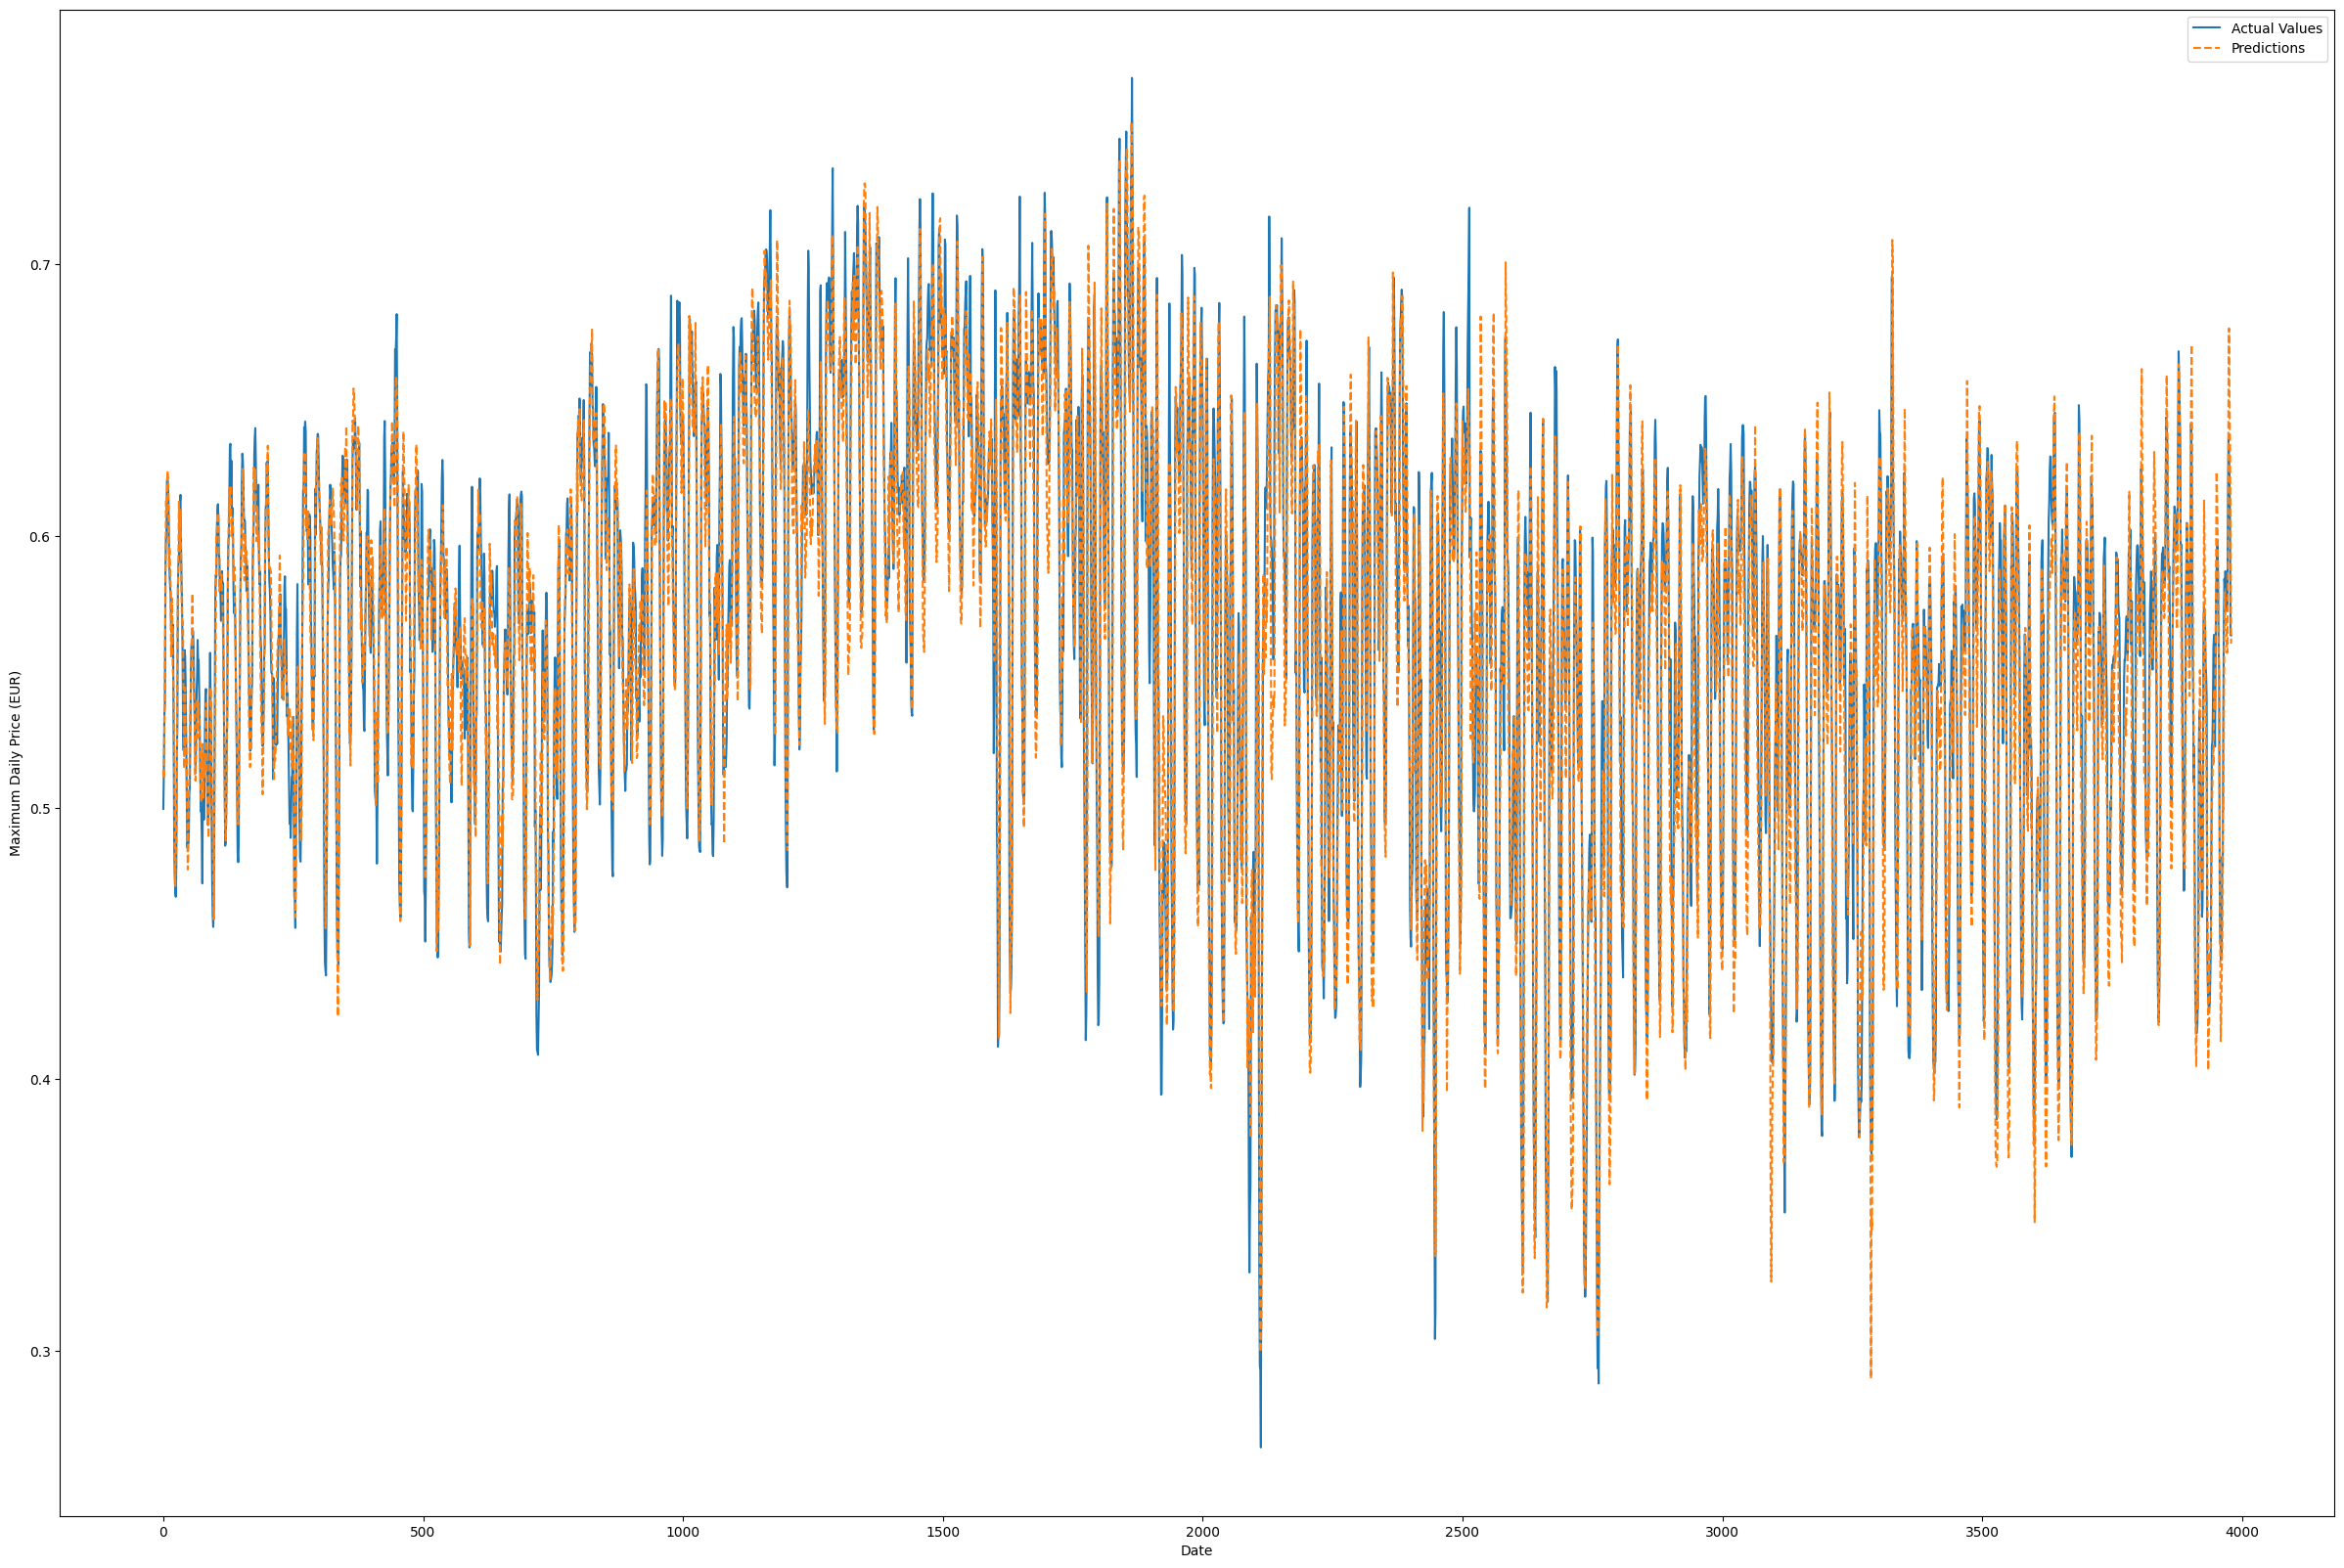

In [ ]:
plotPredictions(pred_cnn)

(3980, 1) (3980,)


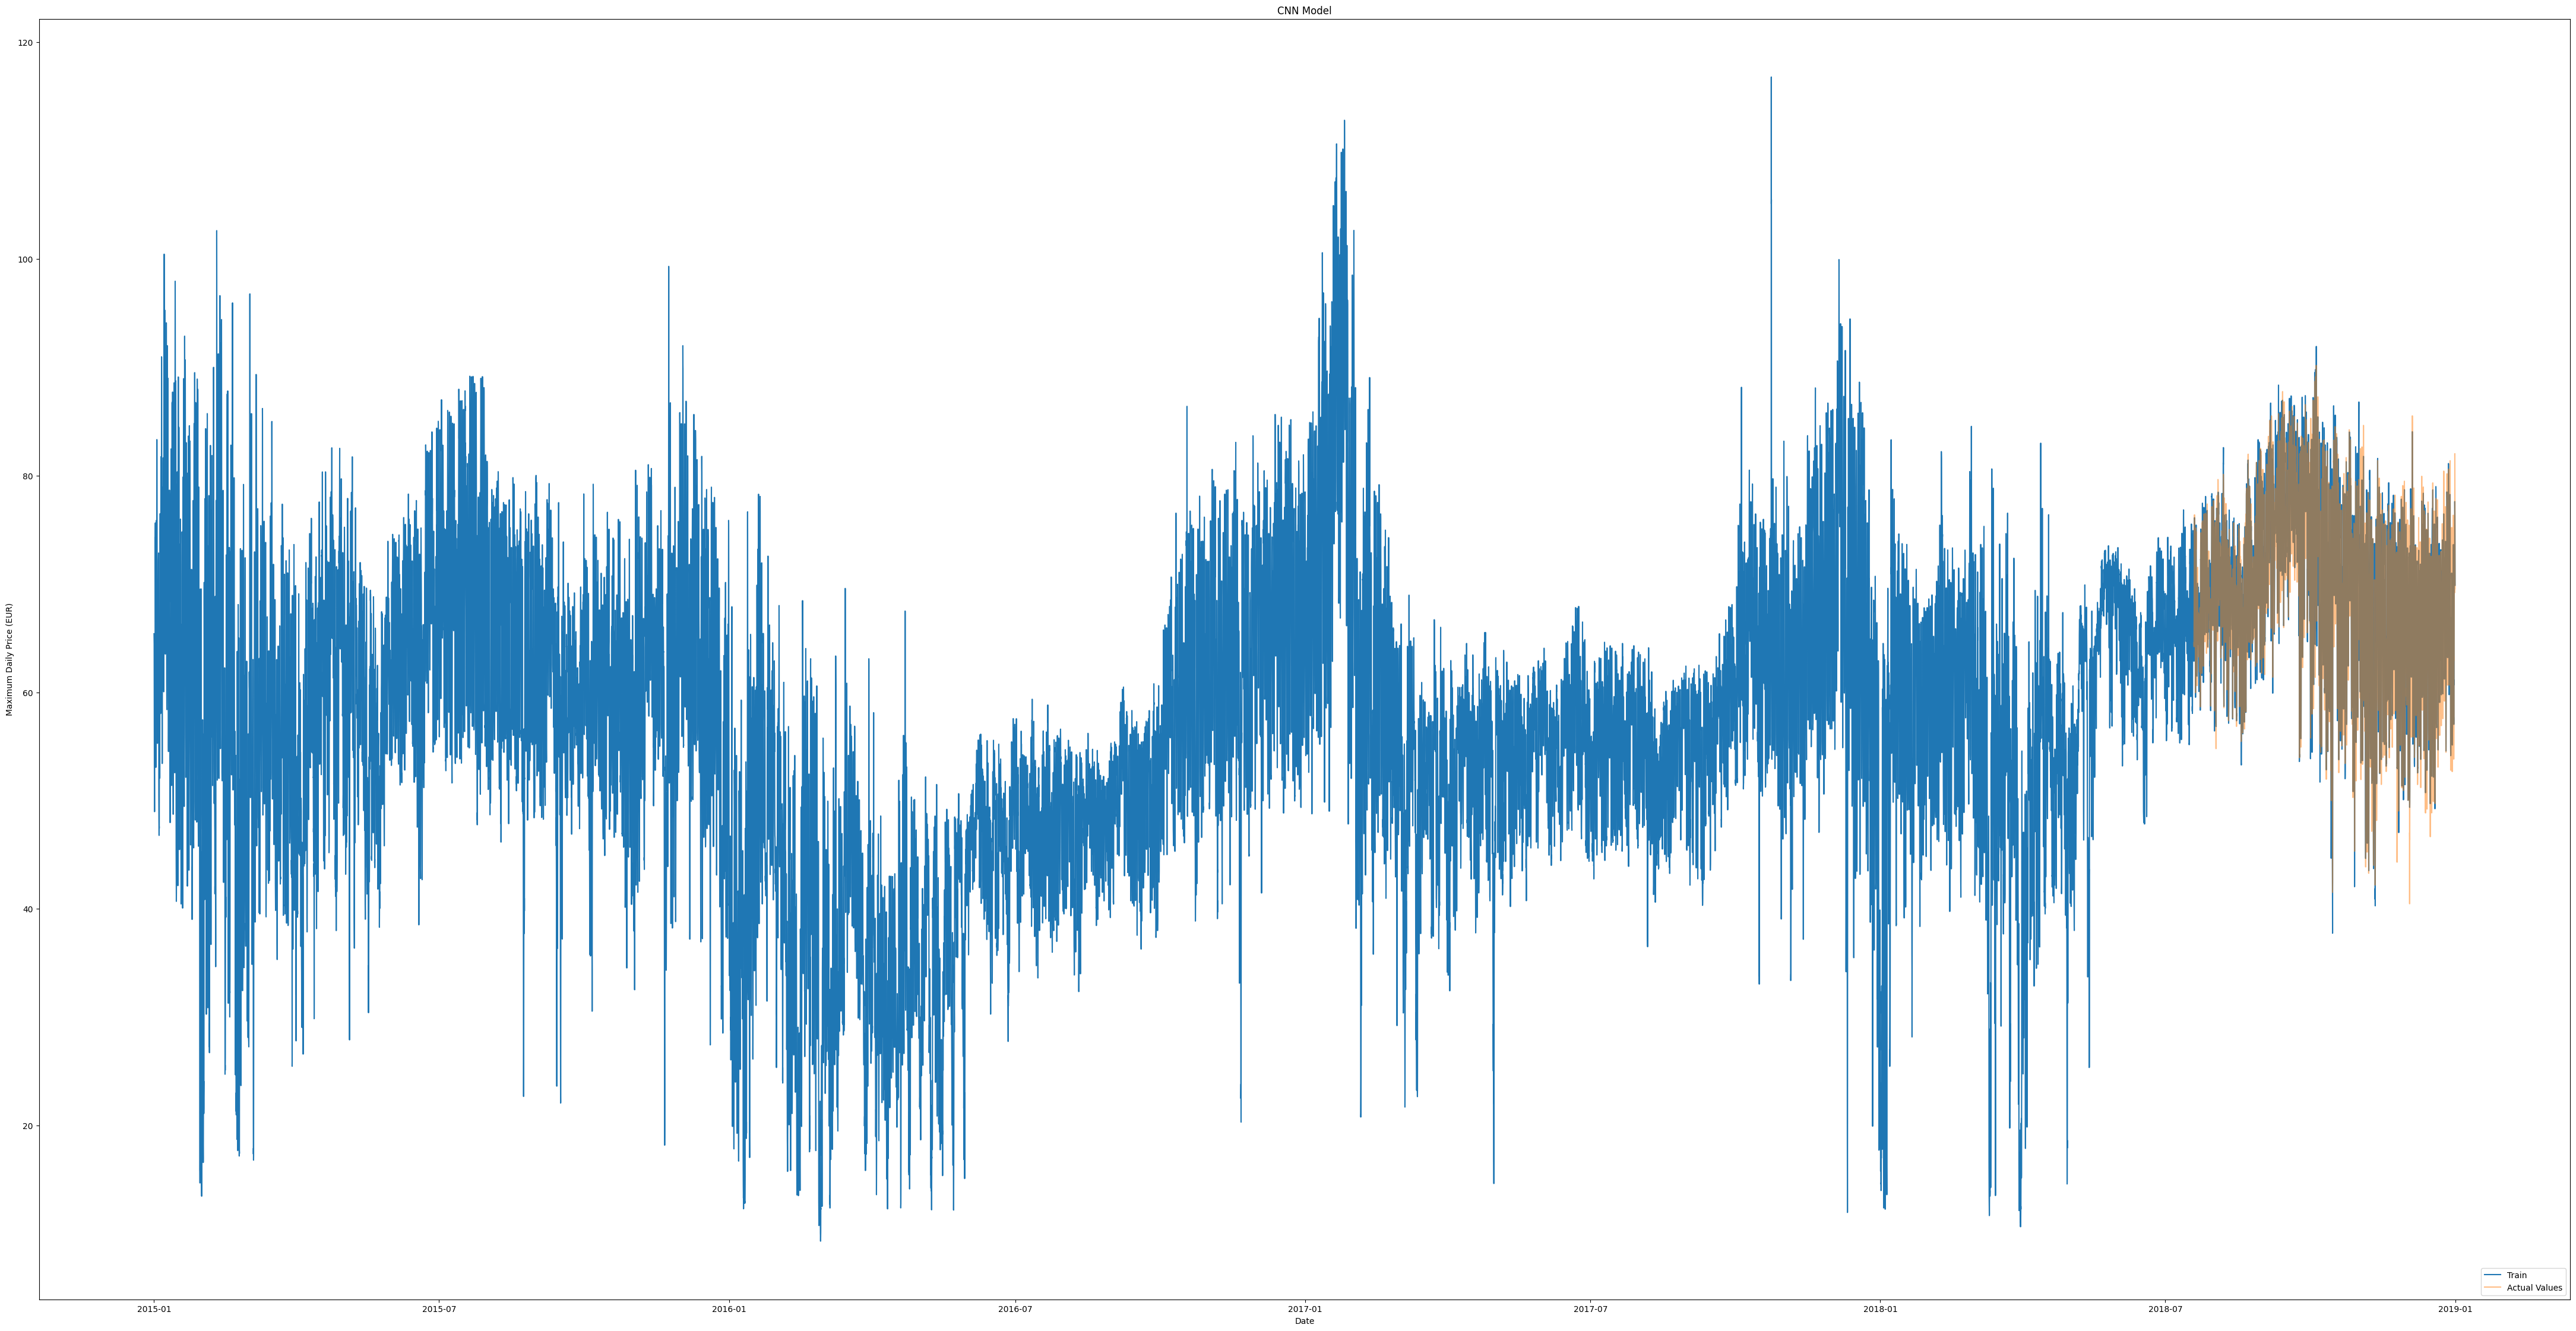

In [ ]:
# plot predictions

# train = price_actual[:tr_len]
# valid = price_actual[tr_len:]
# valid["Predictions"] = predictions_CNN


# plt.figure(figsize = (16,8))
# plt.title("CNN Model")
# plt.xlabel("Date")
# plt.ylabel("Maximum Daily Price (EUR)")
# plt.plot(train["price actual"])
# plt.plot(valid[["price actual", "Predictions"]])
# plt.legend(["Train", "Actual Values", "Predictions"], loc="lower right")
# plt.show()

# plot predictions

valid = scaler_y.inverse_transform(pred_cnn)
print(valid.shape, dataset.index[cv_end_idx+24:].shape)
new = pd.DataFrame(data=valid, index=dataset.index[cv_end_idx+24:])

plt.figure(figsize = (55,28))
plt.title("CNN Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(dataset[["price actual"]])
plt.plot(new, alpha=0.5)
plt.legend(["Train", "Actual Values", "Predictions"], loc="lower right")
plt.show()

### Improve by additional Convolutional Layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:

model_improve = Sequential()

# Convolutional Layer
model_improve.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_improve.add(BatchNormalization())  # Batch normalization layer

# Additional Convolutional Layer
model_improve.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_improve.add(BatchNormalization())  # Batch normalization layer
model_improve.add(MaxPooling1D(pool_size=2))  # Pooling Layer

# Dropout for regularization
model_improve.add(Dropout(0.5))

# Flatten the layer
model_improve.add(Flatten())

# Fully Connected Layers
model_improve.add(Dense(100, activation='relu'))
model_improve.add(Dropout(0.5))  # Dropout for regularization

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Output Layer
model_improve.add(Dense(1, activation='linear'))  # Linear activation for regression

In [ ]:
# Compile the model
model_improve.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
model_improve.fit(X_train_CNN, y_train, epochs=10, batch_size=32, validation_data=(X_test_CNN, y_test),callbacks=[early_stopping, reduce_lr])

Epoch 1/10
35/35 [==============================] - 1s 16ms/step - loss: 0.0535 - mae: 0.1804 - val_loss: 5403.8916 - val_mae: 72.9970 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 1s 15ms/step - loss: 0.0551 - mae: 0.1836 - val_loss: 5445.3462 - val_mae: 73.2746 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 1s 16ms/step - loss: 0.0487 - mae: 0.1708 - val_loss: 5461.2959 - val_mae: 73.3782 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 0s 14ms/step - loss: 0.0470 - mae: 0.1714 - val_loss: 5468.5918 - val_mae: 73.4251 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 0s 13ms/step - loss: 0.0455 - mae: 0.1658 - val_loss: 5466.7031 - val_mae: 73.4119 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 0s 14ms/step - loss: 0.0430 - mae: 0.1583 - val_loss: 5463.5122 - val_mae: 73.3895 - lr: 0.0010
Epoch 7/10
35/35 [==============================] - 1s 16ms/step - loss: 0.0429 - mae: 0.1601 - val_loss: 5465.1

In [ ]:
predictions_CNN_1 = model_improve.predict(X_test_CNN)

10/10 [==============================] - 0s 3ms/step


In [ ]:
predictions_CNN_1 = target_scaler.inverse_transform(predictions_CNN_1)

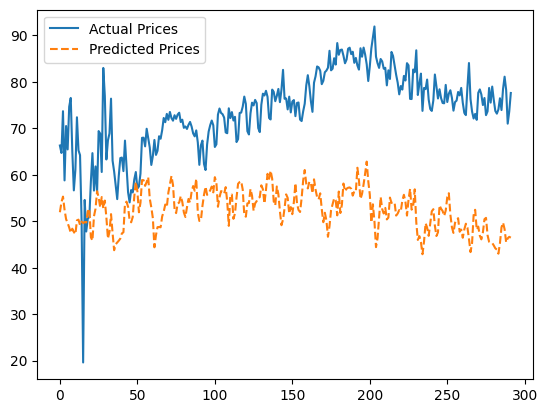

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual Prices')
plt.plot(predictions_CNN_1, label='Predicted Prices', linestyle='--')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions_CNN))
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse}')

Root Mean Squared Error (RMSE) on Test Set: 16.22072301418892


In [ ]:
from sklearn.metrics import mean_squared_error
rmse_1 = np.sqrt(mean_squared_error(y_test, predictions_CNN_1))
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse_1}')

Root Mean Squared Error (RMSE) on Test Set: 23.13879886027798


## Time-distributed Mulitlayer Perceptron Model

The multilayer perceptron consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. In the context of time series forecasting, MLPs can be used to learn a function from a sequence of observations and predict future values.

The architecture utilises several TimeDistributed Dense layers which allows the model to process each time step independently, allowing it to learn temporal patterns effectively.

Source: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/


In [ ]:
def build_model_mlp(
    input_shape,
    activation,
    ff_dim1,
    ff_dim2,
    ff_dim3,
    ff_dim4,
    ff_dim5):

    model = tf.keras.models.Sequential([
    TimeDistributed(Dense(ff_dim1, activation = activation),
                    input_shape=input_shape),
    TimeDistributed(Dense(ff_dim2, activation = activation)),
    TimeDistributed(Dense(ff_dim3, activation = activation)),
    TimeDistributed(Dense(ff_dim4, activation = activation)),
    Flatten(),
    Dense(ff_dim5, activation = activation),
    Dropout(0.1),
    Dense(1)
    ])
    return(model)


In [ ]:
mlp = build_model_mlp(input_shape = (X_train.shape[1], 1), activation = 'relu', ff_dim1 = 50, ff_dim2 = 50, ff_dim3 = 50, ff_dim4 = 50, ff_dim5 = 50)
mlp.compile(optimizer = "adam", loss = "mean_squared_error")
mlp.fit(X_train,y_train, batch_size = 20, epochs = 10)


Epoch 1/10
56/56 [==============================] - 2s 13ms/step - loss: 0.0377
Epoch 2/10
56/56 [==============================] - 1s 13ms/step - loss: 0.0178
Epoch 3/10
56/56 [==============================] - 1s 14ms/step - loss: 0.0151
Epoch 4/10
56/56 [==============================] - 1s 13ms/step - loss: 0.0140
Epoch 5/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0125
Epoch 6/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 7/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 8/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0108
Epoch 9/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 10/10
56/56 [==============================] - 0s 7ms/step - loss: 0.0095


In [ ]:
np.random.seed(42)
mlp_predictions = mlp.predict(X_test)

mlp_predictions = target_scaler.inverse_transform(mlp_predictions)

# rmse
rmse = np.sqrt(np.mean(mlp_predictions - y_test)**2)
print("Root mean square error:", rmse)

10/10 [==============================] - 0s 3ms/step
Root mean square error: 14.454994623889664


In [ ]:
plt.title('Time-distributed model')
plt.plot(y_test, label='Actual Values')
plt.plot(mlp_predictions, label='Predictions', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.legend()
plt.show()

In [ ]:

# plot predictions
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = mlp_predictions


plt.figure(figsize = (16,8))
plt.title("Time-distributed Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Actual Values", "Predictions"], loc="lower right")
plt.show()

### Hyperparameter Tuning

#### Rolling Forecast Origin K-Folds Cross Validation

 In time series, cross-validation becomes more difficult since leaving out an observation does not remove all the associated information due to the correlations with others and by shuffling past and future data, the model learns the future that it is not supposed to know. This means that we cannot rely on techniques such as standard LOOCV and K-folds.

Here, we have designed a cross-validation setup that splits the training data into k folds. It starts by taking the first fold as the training set and the second as the test set. Then at the next iteration takes the first and second folds as the training set and the third as the test set and so on. This preserves the temporal structure and dependencies of the data, while allowing model validation.

Source: https://robjhyndman.com/hyndsight/crossvalidation/#cross-validation-for-time-series




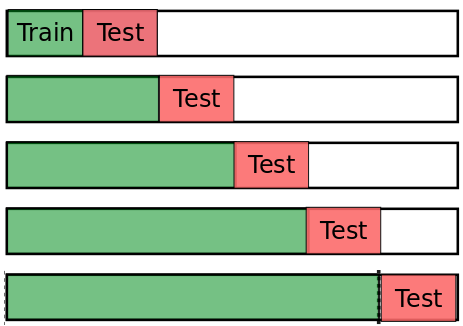

In [ ]:
# Custom rolling origin cross validation function

def rolling_origin_Kfolds(X_train, y_train, k):
  k = k+1
  p = math.ceil(len(X_train)/k)

  for i in range(1,k):
    idx = p*i
    cv_X_train = X_train[:idx]
    cv_y_train = y_train[:idx]

    cv_X_test = X_train[idx:idx + p]
    cv_y_test = y_train[idx:idx + p]

    yield cv_X_train, cv_X_test, cv_y_train, cv_y_test


In [ ]:
# visualise cv train/test lengths

cv_rolling = rolling_origin_Kfolds(X_train, y_train, k = 5)

i = 0
for cv_X_train, cv_X_test, cv_y_train, cv_y_test in cv_rolling:
  print(f'Fold:\t{i+1}')
  print(f'CV X Train:\t{len(cv_X_train)}')
  print(f'CV X Test:\t{len(cv_X_test)}')
  print(f'CV y Train:\t{len(cv_y_train)}')
  print(f'CV y Test:\t{len(cv_y_test)}')
  print("-----------")
  i += 1

Fold:	1
CV X Train:	185
CV X Test:	185
CV y Train:	185
CV y Test:	185
-----------
Fold:	2
CV X Train:	370
CV X Test:	185
CV y Train:	370
CV y Test:	185
-----------
Fold:	3
CV X Train:	555
CV X Test:	185
CV y Train:	555
CV y Test:	185
-----------
Fold:	4
CV X Train:	740
CV X Test:	185
CV y Train:	740
CV y Test:	185
-----------
Fold:	5
CV X Train:	925
CV X Test:	185
CV y Train:	925
CV y Test:	185
-----------


We utilise the Optuna package to perform bayesian optimisation on the build_model function in order to find the best hyperparameters. This is an appropriate tool for this problem since there are many hyperparameters and hence a large parameter search space.


In [ ]:
!pip install optuna
import optuna

In [ ]:
from pickle import TRUE

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    ff_dim1 = trial.suggest_int('ff_dim1', 32, 512, log=True)
    ff_dim2 = trial.suggest_int('ff_dim2', 32, 512, log=True)
    ff_dim3 = trial.suggest_int('ff_dim3', 32, 512, log=True)
    ff_dim4 = trial.suggest_int('ff_dim4', 32, 512, log=True)
    ff_dim5 = trial.suggest_int('ff_dim5', 32, 512, log=True)
    batch_size = trial.suggest_int('batch_size', 1, 1 , log=True)
    epochs = trial.suggest_int('epochs', 1, 1 , log=True)

    cv_scores = []
    for cv_X_train, cv_X_test, cv_y_train, cv_y_test in rolling_origin_Kfolds(X_train, y_train, k):
        model = build_model_mlp(input_shape=(X_train.shape[1], 1),
                activation = activation,
                ff_dim1 = ff_dim1,
                ff_dim2 = ff_dim2,
                ff_dim3 = ff_dim3,
                ff_dim4 = ff_dim4,
                ff_dim5 = ff_dim5)

        model.compile(optimizer = 'adam', loss = "mean_squared_error")
        model.fit(cv_X_train, cv_y_train, batch_size = batch_size, epochs = epochs)
        y_pred = model.predict(cv_X_test)
        rmse = np.sqrt(np.mean(y_pred - cv_y_test)**2)
        cv_scores.append(rmse)

    # Return the average cross-validation score
    return np.mean(cv_scores)


In [ ]:
np.random.seed(42)

k = 5

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2,  n_jobs = -1)

# best parameters
best_params = study.best_params
best_score = study.best_value

print("Best hyperparameters:", best_params)
print("Best cross-validation score (average accuracy):", best_score)


[I 2023-12-07 20:58:05,255] A new study created in memory with name: no-name-366dd3de-6477-4af8-a275-b8fe341a448c


6/6 [==============================] - 0s 9ms/step


[I 2023-12-07 21:00:17,878] Trial 0 finished with value: 0.06504303014585185 and parameters: {'activation': 'relu', 'ff_dim1': 107, 'ff_dim2': 119, 'ff_dim3': 47, 'ff_dim4': 396, 'ff_dim5': 90, 'batch_size': 1, 'epochs': 1}. Best is trial 0 with value: 0.06504303014585185.


Epoch 1/45
185/185 [==============================] - 3s 8ms/step - loss: 0.0451
Epoch 2/45
185/185 [==============================] - 2s 9ms/step - loss: 0.0268
Epoch 3/45
185/185 [==============================] - 1s 8ms/step - loss: 0.0259
Epoch 4/45
185/185 [==============================] - 1s 7ms/step - loss: 0.0222
Epoch 5/45
185/185 [==============================] - 2s 9ms/step - loss: 0.0190
Epoch 6/45
185/185 [==============================] - 2s 13ms/step - loss: 0.0181
Epoch 7/45
185/185 [==============================] - 2s 11ms/step - loss: 0.0139
Epoch 8/45
185/185 [==============================] - 1s 8ms/step - loss: 0.0133
Epoch 9/45
185/185 [==============================] - 2s 9ms/step - loss: 0.0139
Epoch 10/45
185/185 [==============================] - 1s 8ms/step - loss: 0.0120
Epoch 11/45
185/185 [==============================] - 2s 8ms/step - loss: 0.0096
Epoch 12/45
185/185 [==============================] - 2s 9ms/step - loss: 0.0114
Epoch 13/45
185/185 [==

[I 2023-12-07 21:22:24,867] Trial 1 finished with value: 0.0737847747251851 and parameters: {'activation': 'relu', 'ff_dim1': 256, 'ff_dim2': 41, 'ff_dim3': 402, 'ff_dim4': 37, 'ff_dim5': 203, 'batch_size': 1, 'epochs': 45}. Best is trial 0 with value: 0.06504303014585185.


Best hyperparameters: {'activation': 'relu', 'ff_dim1': 107, 'ff_dim2': 119, 'ff_dim3': 47, 'ff_dim4': 396, 'ff_dim5': 90, 'batch_size': 1, 'epochs': 1}
Best cross-validation score (average accuracy): 0.06504303014585185


In [ ]:
mlp = build_model_mlp(input_shape = (X_train.shape[1], 1), activation = best_params['activation'], ff_dim1 = best_params['ff_dim1'], ff_dim2 = best_params['ff_dim2'], ff_dim3 = best_params['ff_dim3'], ff_dim4 = best_params['ff_dim4'], ff_dim5 = best_params['ff_dim5'])
mlp.compile(optimizer = "adam", loss = "mean_squared_error")
mlp.fit(X_train,y_train, batch_size = best_params['batch_size'], epochs = best_params['epochs'])


1110/1110 [==============================] - 48s 39ms/step - loss: 0.0252


In [ ]:
mlp.summary()

In [ ]:
np.random.seed(42)
mlp_predictions = mlp.predict(X_test)

mlp_predictions = target_scaler.inverse_transform(mlp_predictions)

# rmse
rmse = np.sqrt(np.mean(mlp_predictions - y_test)**2)
print("Root mean square error:", rmse)

10/10 [==============================] - 0s 9ms/step
Root mean square error: 8.049989939650445


In [ ]:
plt.title('Time-distributed model')
plt.plot(y_test, label='Actual Values')
plt.plot(mlp_predictions, label='Predictions', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.legend()
plt.show()

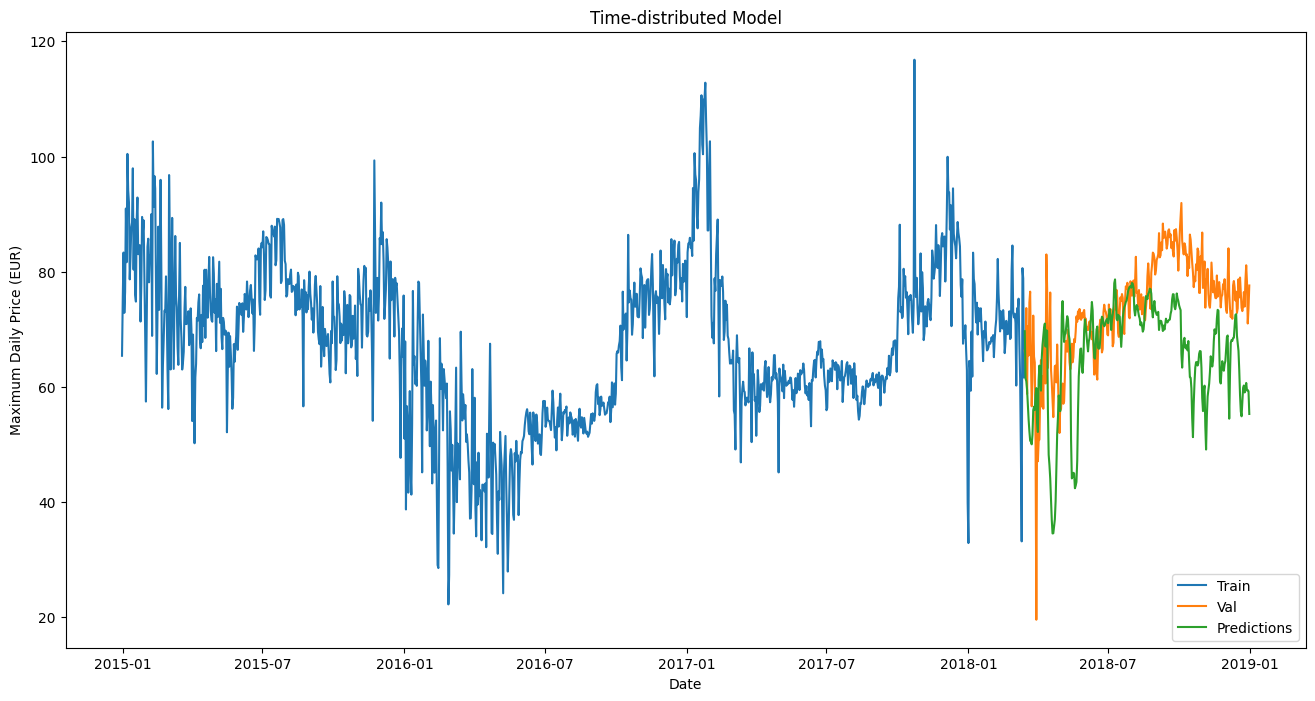

In [ ]:

# plot predictions
train = price_actual[:tr_len]
valid = price_actual[tr_len:]
valid["Predictions"] = mlp_predictions


plt.figure(figsize = (16,8))
plt.title("Time-distributed Model")
plt.xlabel("Date")
plt.ylabel("Maximum Daily Price (EUR)")
plt.plot(train["price actual"])
plt.plot(valid[["price actual", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

Note that we have not tuned every single possible hyperparameter that we could and that we limit the range of parameter space and the number of trials to save on compute. However, if there were more time, we would have performed a more extensive optimisation.


After performing hyperparameter tuning, one can observe a marked improvement in the performance of this model. From the graph, the predictions of the tuned model follow much closer to the real values and the RMSE has been halved. Hence, this was clearly a worthwhile procedure to implement.

### Performance Optimisation

Here, we take advantage of the 'n_jobs' argument in the optuna algorithm to parallelise this computationally costly process and hence speed-up the code. This works by distributing the computation of each trial (iteration) to a different core, up to the number of cores available, and each trial is computed in parallel. Source: https://medium.com/optuna/parallel-hyperparameter-tuning-with-optuna-and-kubeflow-pipelines-4ef05ce614ae


# Comparison and discussion

# Conclusion